# Домашняя работа 9 (?? баллов). Предсказание победителя в Dota2.

В этом финальном домашнем задании вы будет работать над более-менее реальными данными - сведениями из онлайн игры dota2. Примените все знания, которые вы полусили за этот семестр. Попробуйте сгенерировать разные признаки.

По факту это перове соревнование в ML, в коттором мы предлагаем вам поучаствовать.

Изначально это задание было в курсе "Введение в машинное обучение" от ВШЭ.

## Задание

1. Скачайте данные отсюда: https://inclass.kaggle.com/c/dota-2-win-probability-prediction
2. Прочитайте задание в файле `final-statement.ipynb`. Мы его не меняли и оставили таким, каким оно было в оригинальном курсе "Введение в машинное обучение".
3. Проведите всё исследование в одном jupyter ноутбуке.
4. Отправьте результат вашего предсказания на тестовой выборке на kaggle и в почте укажите что у вас получилось.
5. Сохраниет решение в github и отправьте ссылку на ноутбук на почту с темой `ML Homework #9: Name Surname`
6. Потом вы получите на проверку ноутбук сокурсника и задание на проверку. Вам нужно будет проверить всё и оформить отчет, отправив его в виде текста на почту в ответ на письмо с заданием.


**Дедлайны**

Поставим первый дедлайн на решение до `07.01.2018`, второй - на проверку, до `15.01.2018`. Мы бы были рады увидеть первые решения еще в этому году.

In [93]:
import numpy as np
import pandas as pd

import scipy as sp

import sklearn as sk
import xgboost as xgb
import tensorflow as tf
import keras

import seaborn as sns
import pylab
from matplotlib import pyplot as plt
%matplotlib inline

import pickle

In [94]:
train = pd.read_csv('./../data/features.csv', index_col='match_id')
test = pd.read_csv('./../data/features_test.csv', index_col='match_id')

train.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire'
        ], axis=1, inplace=True)
'''test.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire'
        ], axis=1, inplace=True)
'''

"test.drop(['duration', \n         'tower_status_radiant', \n         'tower_status_dire', \n         'barracks_status_radiant', \n         'barracks_status_dire'\n        ], axis=1, inplace=True)\n"

In [95]:
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,radiant_win
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,1
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,0


In [96]:
X = train.drop(["radiant_win"], axis=1)
y = train.radiant_win

In [5]:
#X.head()

In [6]:
#y.head()

In [44]:
def save_answer(X, clf, filename):
    y = clf.predict_proba(X)[:, 1]
    result = pd.DataFrame({'radiant_win': y}, index=test.index)
    result.index.name = 'match_id'
    result.to_csv('./data/kaggle_{}.csv'.format(filename))

## Preprocessing data

In [45]:
fill_cont = lambda df: df.fillna(0, inplace=True)
del_cat = lambda df, to_del: df.drop(to_del, axis=1, inplace=True)

def save_prep_df(df, file_name):
    df.to_csv(file_name, sep='\t', encoding='utf-8')

In [10]:
heroes = pd.read_csv('./../data/dictionaries/heroes.csv')
heroes.head()

,id,localized_name,name
0,1,Anti-Mage,antimage
1,2,Axe,axe
2,3,Bane,bane
3,4,Bloodseeker,bloodseeker
4,5,Crystal Maiden,crystal_maiden


In [11]:
path = './data/'

In [12]:
hers_cat = [('r%d_hero' % (i // 2)) if i % 2 == 0 else ('d%d_hero' % ((i + 1) // 2)) for i in range(1, 11)]
to_del_cat = ['lobby_type']
to_del_cat.extend(hers_cat)

##  Подход №1: градиентный бустинг "в лоб"

1)

In [13]:
X.count()

start_time                     97230
lobby_type                     97230
r1_hero                        97230
r1_level                       97230
r1_xp                          97230
r1_gold                        97230
r1_lh                          97230
r1_kills                       97230
r1_deaths                      97230
r1_items                       97230
r2_hero                        97230
r2_level                       97230
r2_xp                          97230
r2_gold                        97230
r2_lh                          97230
r2_kills                       97230
r2_deaths                      97230
r2_items                       97230
r3_hero                        97230
r3_level                       97230
r3_xp                          97230
r3_gold                        97230
r3_lh                          97230
r3_kills                       97230
r3_deaths                      97230
r3_items                       97230
r4_hero                        97230
r

In [14]:
print(len(X))
X.count()[X.count() < len(X)]

97230


first_blood_time               77677
first_blood_team               77677
first_blood_player1            77677
first_blood_player2            53243
radiant_bottle_time            81539
radiant_courier_time           96538
radiant_flying_courier_time    69751
radiant_first_ward_time        95394
dire_bottle_time               81087
dire_courier_time              96554
dire_flying_courier_time       71132
dire_first_ward_time           95404
dtype: int64

- Как было сказано в описании датасета features: признаки события "первая кровь"(first blood) принимают пропущенные значения, если такое событие не произошло в первые 5 минут.
- К примеру(для признака dire_bottle_time), первое приобретение командой предмета "bottle" могло произойти по истечению первых 5 минут.

In [15]:
X_copy = X.copy()

In [16]:
fill_cont(X)
save_prep_df(X, path + 'x_fill_na_by_zero.csv')

In [17]:
X_kaggle = test.copy()
fill_cont(X_kaggle)
save_prep_df(X_kaggle, path + 'x_kaggle_fill_na_by_zero.csv')

In [18]:
X_kaggle_copy = X_kaggle.copy()

2) radiant_win - целевой столбец

#### Приступим к обучению градиентного бустинга! :)

In [111]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

import time
import datetime

In [113]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
from tqdm import *

In [22]:
n_estimators = [j*10**i for i in range(3) for j in range(1, 5) ]

scores = []

for n in tqdm_notebook(n_estimators):
    print("n_estimators =", n)
    start_time = datetime.datetime.now()
    clf = GradientBoostingClassifier(n_estimators=n, random_state=42)
    clf_scores = cross_val_score(clf, X, y, cv=skf, scoring='roc_auc', n_jobs=7)
    print("Time elapsed:", datetime.datetime.now() - start_time)
    print("clf_scores:", clf_scores)
    print("Mean score:", np.mean(clf_scores), '\n')
    scores.append(np.mean(clf_scores))

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

n_estimators = 1
Time elapsed: 0:00:06.232293
clf_scores: [ 0.59766379  0.60356018  0.58924937  0.59939272  0.59701713]
Mean score: 0.597376638002 

n_estimators = 2
Time elapsed: 0:00:04.631774
clf_scores: [ 0.60830018  0.61756386  0.60230958  0.61385012  0.61473102]
Mean score: 0.611350951549 

n_estimators = 3
Time elapsed: 0:00:06.804685
clf_scores: [ 0.62066871  0.62644797  0.61368336  0.62134806  0.62194419]
Mean score: 0.620818459718 

n_estimators = 4
Time elapsed: 0:00:07.729117
clf_scores: [ 0.6315874   0.63874442  0.61951324  0.62606631  0.62463857]
Mean score: 0.628109986684 

n_estimators = 10
Time elapsed: 0:00:16.149923
clf_scores: [ 0.66524552  0.66886934  0.66049353  0.66633225  0.66523737]
Mean score: 0.665235600898 

n_estimators = 20
Time elapsed: 0:00:30.922212
clf_scores: [ 0.68261943  0.68239392  0.6801135   0.6846385   0.67999394]
Mean score: 0.681951856478 

n_estimators = 30
Time elapsed: 0:00:45.127542
clf_scores: [ 0.69045207  0.68911601  0.68753498  0.69224

Text(0,0.5,'score')

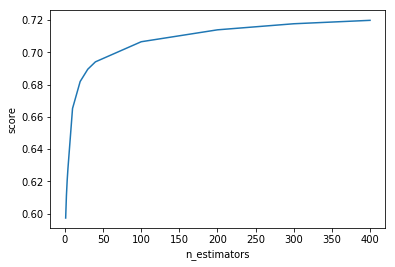

In [23]:
plt.plot(n_estimators, scores)
plt.xlabel('n_estimators')
plt.ylabel('score')

Кросс-валидация для градиентного бустинга с 30 деревьями заняла 0:00:38.286640. Показатель roc_auc приблизительно равен 0.68957.

Увеличение числа деревьев увеличивает показатель roc_auc, постепенно приближая его к 0.72.
Чтобы увеличить качество имеет смысл увеличить количество деревьев(взять их больше 30 штук). Чтобы обучение проходило быстрее можно взять подмножество выборки(например, половину), уменьшить глубину деревьев.

In [24]:
from sklearn.model_selection import RandomizedSearchCV

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

In [27]:
clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [28]:
param_dist = {
    "learning_rate": uniform(1e-2, 1e-1),
    "max_depth": [2, 3],
    "max_features": sp_randint(1, 5),
    "min_samples_split": sp_randint(2, 5),
    "min_samples_leaf": sp_randint(1, 5),
}

In [29]:
random_search = RandomizedSearchCV(
    clf,
    scoring='roc_auc',
    param_distributions=param_dist,
    n_iter=50,
    n_jobs=7,
    cv=skf,
    random_state=42,
    verbose=5
)

In [30]:
%%time

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=2, max_features=3, learning_rate=0.0474540118847 
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=2, max_features=3, learning_rate=0.0474540118847 
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=2, max_features=3, learning_rate=0.0474540118847 
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=2, max_features=3, learning_rate=0.0474540118847 
[CV] max_depth=2, min_samples_leaf=3, min_samples_split=2, max_features=3, learning_rate=0.0474540118847 
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=4, max_features=3, learning_rate=0.0696850157946 
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=4, max_features=3, learning_rate=0.0696850157946 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=2, max_features=3, learning_rate=0.0474540118847, score=0.6839204046103771, total=   4.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples

[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    6.3s


[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=2, max_features=3, learning_rate=0.0474540118847, score=0.6883530918942018, total=   6.4s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=4, max_features=4, learning_rate=0.0559248891966 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=4, max_features=3, learning_rate=0.0696850157946, score=0.6917449182835349, total=   6.9s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=4, max_features=4, learning_rate=0.0559248891966 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=4, max_features=3, learning_rate=0.0696850157946, score=0.7014976816739364, total=  11.3s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=4, max_features=4, learning_rate=0.0559248891966 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=4, max_features=3, learning_rate=0.0696850157946, score=0.6999817961073403, total=   8.4s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=4, max_features=4, learning_rate=0.055

[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=4, max_features=2, learning_rate=0.0556069984217, score=0.6819637345255789, total=   6.0s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=4, max_features=3, learning_rate=0.108323088581 
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=4, max_features=3, learning_rate=0.108323088581 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=4, max_features=2, learning_rate=0.0556069984217, score=0.6914803965267521, total=   5.7s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=2, max_features=3, learning_rate=0.0780307538588 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=4, max_features=2, learning_rate=0.0556069984217, score=0.6829228088875396, total=   6.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=2, max_features=3, learning_rate=0.0780307538588 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=4, max_features=3, learning_rate=0.108323088581, score=0.6981864883985542, total

[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:  1.2min


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=4, max_features=4, learning_rate=0.0197672114006, score=0.6863933713477053, total=   9.8s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=3, max_features=4, learning_rate=0.0491060607573 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, max_features=3, learning_rate=0.0709996657783, score=0.692266662571224, total=   8.9s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=3, max_features=4, learning_rate=0.0491060607573 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=4, max_features=4, learning_rate=0.0197672114006, score=0.6764475894024933, total=  11.2s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=3, max_features=4, learning_rate=0.0491060607573 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, max_features=3, learning_rate=0.0709996657783, score=0.6959725573201494, total=   8.0s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=3, max_features=4, learning_rate=0.0491

[CV] max_depth=3, min_samples_leaf=4, min_samples_split=2, max_features=1, learning_rate=0.0928737509152 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=4, max_features=1, learning_rate=0.0425330330763, score=0.6951765883232776, total=   5.2s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=2, max_features=1, learning_rate=0.0928737509152 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=4, max_features=1, learning_rate=0.0425330330763, score=0.6952300585960509, total=   5.4s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=2, max_features=1, learning_rate=0.0928737509152 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=4, max_features=1, learning_rate=0.0425330330763, score=0.6893155043738428, total=   6.0s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, max_features=1, learning_rate=0.0240924224975 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=4, max_features=1, learning_rate=0.0425330330763, score=0.6958367931106341, to

[CV] max_depth=3, min_samples_leaf=3, min_samples_split=4, max_features=2, learning_rate=0.0829606178338 
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=3, max_features=1, learning_rate=0.0215869059525, score=0.6837327098417503, total=   4.7s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=4, max_features=2, learning_rate=0.0829606178338 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=2, max_features=3, learning_rate=0.019541011649, score=0.669305290026104, total=   6.9s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=4, max_features=2, learning_rate=0.0829606178338 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=2, max_features=3, learning_rate=0.019541011649, score=0.6801093470121639, total=   6.9s
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=2, max_features=3, learning_rate=0.019541011649, score=0.6797678814252288, total=   7.9s
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=2, max_features=3, learning_rate=0.019541

[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  3.0min


[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=4, max_features=3, learning_rate=0.0125419126744, score=0.6675424095937535, total=   5.2s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=3, max_features=4, learning_rate=0.0575370223182 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=4, max_features=3, learning_rate=0.0125419126744, score=0.673124849465475, total=   5.4s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=3, max_features=4, learning_rate=0.0575370223182 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=4, max_features=3, learning_rate=0.0125419126744, score=0.6782183667976144, total=   5.9s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=3, max_features=4, learning_rate=0.0575370223182 
[CV]  max_depth=2, min_samples_leaf=3, min_samples_split=3, max_features=3, learning_rate=0.0593795596364, score=0.6858005413121226, total=   6.5s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=3, max_features=4, learning_rate=0.0575

[CV] max_depth=2, min_samples_leaf=1, min_samples_split=4, max_features=1, learning_rate=0.0418003474972 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, max_features=2, learning_rate=0.0983280258919, score=0.699947706948636, total=   6.7s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=4, max_features=1, learning_rate=0.0418003474972 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, max_features=2, learning_rate=0.0983280258919, score=0.7003731675370929, total=   7.4s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=4, max_features=1, learning_rate=0.0418003474972 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, max_features=2, learning_rate=0.0983280258919, score=0.7035533838001685, total=   7.4s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=4, max_features=1, learning_rate=0.0527107788626 
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, max_features=2, learning_rate=0.0983280258919, score=0.6966652021429716, tot

[CV] max_depth=2, min_samples_leaf=2, min_samples_split=3, max_features=1, learning_rate=0.109774048505 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, max_features=1, learning_rate=0.079630427284, score=0.6842335203436039, total=   4.8s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=3, max_features=1, learning_rate=0.109774048505 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=3, max_features=1, learning_rate=0.0503836171058, score=0.6900024924749063, total=   6.7s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=3, max_features=1, learning_rate=0.109774048505 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, max_features=1, learning_rate=0.079630427284, score=0.6924325421289035, total=   6.5s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=3, max_features=1, learning_rate=0.109774048505 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, max_features=1, learning_rate=0.079630427284, score=0.6898307722959092, total=   

[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=3, max_features=2, learning_rate=0.0467783132719, score=0.6967762331449983, total=   6.1s


[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:  4.9min finished


CPU times: user 1min 20s, sys: 2.01 s, total: 1min 22s
Wall time: 4min 56s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
          error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=7,
          param_distributions={'max_depth': [2, 3], 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdb70adafd0>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdb139a6a20>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdb139a6748>, 'max_features

In [31]:
print('CV score on', random_search.best_params_, "=", random_search.best_score_)
print("Значение score на отложенной выборке =", random_search.score(X_test, y_test))

scs = cross_val_score(
          GradientBoostingClassifier(
              **random_search.best_params_, n_estimators=100, random_state=42
          ),
          X, y, cv=skf, scoring='roc_auc', n_jobs=7
      )

print('CV roc_auc на всей выборке =', 
      scs
     )
print('Mean cv roc_auc на всей выборке =', 
      np.mean(scs)
     )

CV score on {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 4, 'learning_rate': 0.10856504541106007, 'max_features': 3} = 0.701628405618
Значение score на отложенной выборке = 0.700832633903
CV roc_auc на всей выборке = [ 0.70122474  0.70350836  0.70033685  0.70282422  0.70236716]
Mean cv roc_auc на всей выборке = 0.702052265173


In [32]:
clf = GradientBoostingClassifier(
              **random_search.best_params_, n_estimators=100, random_state=42
          )
clf.fit(X, y)
save_answer(X_kaggle, clf)

Итоговый score на kaggle у последней модели = 0.70482

## Подход №2: Логистическая регрессия

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

Подготавливаем данные для логистической регрессии:

In [34]:
scaler = StandardScaler()

In [35]:
X = scaler.fit_transform(X)

In [36]:
Cs = [j*10.**i for i in range(-5, 6) for j in range(1, 3) ]

scores = []

for C in tqdm_notebook(Cs):
    print("C =", C)
    start_time = datetime.datetime.now()
    clf = LogisticRegression(C=C, random_state=42, n_jobs=7)
    clf_scores = cross_val_score(clf, X, y, cv=skf, scoring='roc_auc', n_jobs=7)
    print("Time elapsed:", datetime.datetime.now() - start_time)
    print("clf_scores:", clf_scores, '\n')
    print("Mean score:", np.mean(clf_scores))
    scores.append(np.mean(clf_scores))

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

C = 1e-05


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:02.583226
clf_scores: [ 0.69329521  0.70115425  0.69265952  0.69387443  0.69466862] 

Mean score: 0.695130408397
C = 2e-05


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.647180
clf_scores: [ 0.69780784  0.70555333  0.69795932  0.69863219  0.69956037] 

Mean score: 0.699902610082
C = 0.0001


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.459110
clf_scores: [ 0.70868971  0.71545183  0.71089269  0.71027989  0.71137277] 

Mean score: 0.711337377636
C = 0.0002


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:06.513798
clf_scores: [ 0.71139628  0.71758915  0.71410744  0.71330586  0.71429224] 

Mean score: 0.714138191639
C = 0.001


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:05.822663
clf_scores: [ 0.71362343  0.71889037  0.71658512  0.71604294  0.7166536 ] 

Mean score: 0.716359093099
C = 0.002


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:09.936016
clf_scores: [ 0.71383242  0.71889862  0.71675982  0.71631705  0.71684207] 

Mean score: 0.71652999684
C = 0.01


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.689374
clf_scores: [ 0.71392952  0.71881568  0.71682734  0.71641971  0.71689665] 

Mean score: 0.716577780375
C = 0.02


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.878856
clf_scores: [ 0.71392927  0.71878512  0.71681616  0.71641234  0.71689369] 

Mean score: 0.716567317129
C = 0.1


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.700522
clf_scores: [ 0.71393129  0.71877281  0.71681651  0.71640772  0.71687904] 

Mean score: 0.716561474016
C = 0.2


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:08.564507
clf_scores: [ 0.71392981  0.7187713   0.71681596  0.71640613  0.7168777 ] 

Mean score: 0.716560179627
C = 1.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.874043
clf_scores: [ 0.71392796  0.71876934  0.7168149   0.7164039   0.71687558] 

Mean score: 0.716558336543
C = 2.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:09.681271
clf_scores: [ 0.71392764  0.71876824  0.71681471  0.71640366  0.71687558] 

Mean score: 0.716557965816
C = 10.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:09.235706
clf_scores: [ 0.71392777  0.71876737  0.7168148   0.71640324  0.71687531] 

Mean score: 0.716557698878
C = 20.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:08.707825
clf_scores: [ 0.71392788  0.71876741  0.71681481  0.71640328  0.71687519] 

Mean score: 0.716557713703
C = 100.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:08.365257
clf_scores: [ 0.71392794  0.71876726  0.71681462  0.71640333  0.71687498] 

Mean score: 0.71655762684
C = 200.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:10.270032
clf_scores: [ 0.71392785  0.71876729  0.71681466  0.71640334  0.71687499] 

Mean score: 0.716557626842
C = 1000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:08.911390
clf_scores: [ 0.71392783  0.71876729  0.71681464  0.71640334  0.71687496] 

Mean score: 0.716557612013
C = 2000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:08.884121
clf_scores: [ 0.71392783  0.71876729  0.71681464  0.71640334  0.71687496] 

Mean score: 0.716557612013
C = 10000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:08.280662
clf_scores: [ 0.71392783  0.7187673   0.71681465  0.71640334  0.71687497] 

Mean score: 0.716557618368
C = 20000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:10.750194
clf_scores: [ 0.71392783  0.7187673   0.71681465  0.71640334  0.71687497] 

Mean score: 0.716557618368
C = 100000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.632398
clf_scores: [ 0.71392783  0.7187673   0.71681465  0.71640334  0.71687495] 

Mean score: 0.716557614131
C = 200000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:09.375060
clf_scores: [ 0.71392783  0.7187673   0.71681465  0.71640334  0.71687495] 

Mean score: 0.716557614131



Text(0,0.5,'score')

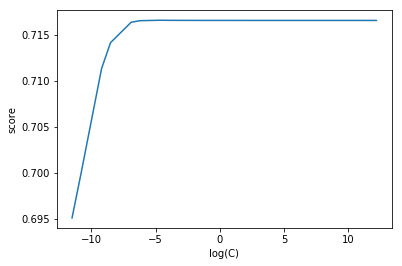

In [38]:
plt.plot(np.log(Cs), scores)
plt.xlabel("log(C)")
plt.ylabel("score")

In [41]:
sorted(list(zip(Cs, scores)), key=lambda item: item[1], reverse=True)

[(0.01, 0.7165777803749247),
 (0.02, 0.71656731712884902),
 (0.1, 0.71656147401593662),
 (0.2, 0.71656017962714991),
 (1.0, 0.71655833654333878),
 (2.0, 0.7165579658156378),
 (20.0, 0.7165577137030541),
 (10.0, 0.71655769887844933),
 (200.0, 0.71655762684210311),
 (100.0, 0.71655762683985691),
 (10000.0, 0.71655761836819898),
 (20000.0, 0.71655761836819898),
 (100000.0, 0.71655761413081065),
 (200000.0, 0.71655761413081065),
 (1000.0, 0.71655761201253676),
 (2000.0, 0.71655761201253665),
 (0.002, 0.71652999683954999),
 (0.001, 0.71635909309898416),
 (0.0002, 0.71413819163936243),
 (0.0001, 0.71133737763559801),
 (2e-05, 0.69990261008203636),
 (1e-05, 0.69513040839677165)]

Наилучшее значение показателя roc_auc достигается при C = 0.01, оно равно 0.7165777803749247.
Подобное значение достигается градиентным бустингом при n_estimators = 300, roc_auc = 0.717738717079.

Логистическая регрессия при этом обучается и вычисляется быстрее градиентного бустинга.

#### Уберем категориальные признаки

In [53]:
X = X_copy.copy()
fill_cont(X)
del_cat(X, to_del_cat)

scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

In [54]:
X_kaggle = X_kaggle_copy.copy()
fill_cont(X_kaggle)
del_cat(X_kaggle, to_del_cat)

X_kaggle = pd.DataFrame(scaler.transform(X_kaggle), index=X_kaggle.index, columns=X_kaggle.columns)

In [46]:
Cs = [j*10.**i for i in range(-5, 6) for j in range(1, 3) ]

scores = []

for C in tqdm_notebook(Cs):
    print("C =", C)
    start_time = datetime.datetime.now()
    clf = LogisticRegression(C=C, random_state=42, n_jobs=7)
    clf_scores = cross_val_score(clf, X, y, cv=skf, scoring='roc_auc', n_jobs=7)
    print("Time elapsed:", datetime.datetime.now() - start_time)
    print("clf_scores:", clf_scores, '\n')
    print("Mean score:", np.mean(clf_scores))
    scores.append(np.mean(clf_scores))

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

C = 1e-05


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:02.136779
clf_scores: [ 0.69330941  0.70117033  0.69255193  0.69382808  0.69462338] 

Mean score: 0.695096625849
C = 2e-05


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:02.644879
clf_scores: [ 0.69782693  0.70560619  0.69782213  0.69856971  0.69953603] 

Mean score: 0.699872198352
C = 0.0001


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.065072
clf_scores: [ 0.70877599  0.71555698  0.71078833  0.71026059  0.7114739 ] 

Mean score: 0.711371159146
C = 0.0002


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:08.290164
clf_scores: [ 0.71150832  0.71769546  0.7140276   0.71333383  0.7144171 ] 

Mean score: 0.714196462746
C = 0.001


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:05.465985
clf_scores: [ 0.71376739  0.7190144   0.71660828  0.71612694  0.71678336] 

Mean score: 0.71646007226
C = 0.002


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:06.152159
clf_scores: [ 0.71397977  0.7190205   0.71679401  0.71640137  0.7169756 ] 

Mean score: 0.716634251179
C = 0.01


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.130862
clf_scores: [ 0.71408383  0.71893994  0.71685882  0.71651687  0.71702554] 

Mean score: 0.716685000352
C = 0.02


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:09.284662
clf_scores: [ 0.71409333  0.71892082  0.71684888  0.71651145  0.71701657] 

Mean score: 0.716678210229
C = 0.1


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.307987
clf_scores: [ 0.71409606  0.71889711  0.71684397  0.7164941   0.71700628] 

Mean score: 0.716667503148
C = 0.2


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.509771
clf_scores: [ 0.71409701  0.7188932   0.71684219  0.71649172  0.71700337] 

Mean score: 0.716665496866
C = 1.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.778804
clf_scores: [ 0.71409964  0.71889118  0.7168409   0.71649107  0.71700207] 

Mean score: 0.7166649714
C = 2.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:10.613594
clf_scores: [ 0.71409987  0.71889112  0.71684013  0.716491    0.71700269] 

Mean score: 0.716664962933
C = 10.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.224955
clf_scores: [ 0.71409942  0.71889112  0.71683976  0.71649099  0.71700242] 

Mean score: 0.716664742616
C = 20.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:08.230705
clf_scores: [ 0.71409933  0.71889108  0.71683975  0.71649099  0.71700232] 

Mean score: 0.71666469389
C = 100.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:08.232222
clf_scores: [ 0.71409927  0.71889111  0.71683971  0.71649103  0.71700228] 

Mean score: 0.716664679061
C = 200.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.273098
clf_scores: [ 0.71409923  0.71889117  0.71683968  0.71649104  0.71700231] 

Mean score: 0.7166646833
C = 1000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:08.032151
clf_scores: [ 0.71409924  0.71889126  0.71683967  0.71649109  0.71700232] 

Mean score: 0.716664715077
C = 2000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.368681
clf_scores: [ 0.71409923  0.71889127  0.71683966  0.7164911   0.71700234] 

Mean score: 0.716664719315
C = 10000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.444560
clf_scores: [ 0.71409923  0.71889126  0.71683964  0.7164911   0.71700233] 

Mean score: 0.71666471084
C = 20000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.309238
clf_scores: [ 0.71409923  0.71889126  0.71683965  0.7164911   0.71700233] 

Mean score: 0.716664712959
C = 100000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.912149
clf_scores: [ 0.71409923  0.71889126  0.71683965  0.7164911   0.71700233] 

Mean score: 0.716664712959
C = 200000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.324994
clf_scores: [ 0.71409923  0.71889126  0.71683965  0.7164911   0.71700233] 

Mean score: 0.716664712959



Text(0,0.5,'score')

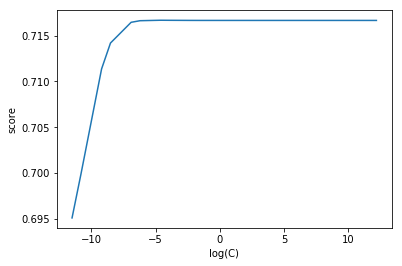

In [47]:
plt.plot(np.log(Cs), scores)
plt.xlabel("log(C)")
plt.ylabel("score")

In [48]:
sorted(list(zip(Cs, scores)), key=lambda item: item[1], reverse=True)

[(0.01, 0.71668500035182281),
 (0.02, 0.71667821022942957),
 (0.1, 0.71666750314847893),
 (0.2, 0.71666549686590764),
 (1.0, 0.71666497140011332),
 (2.0, 0.716664962933387),
 (10.0, 0.71666474261551749),
 (2000.0, 0.71666471931458386),
 (1000.0, 0.71666471507696927),
 (20000.0, 0.71666471295892153),
 (100000.0, 0.71666471295892153),
 (200000.0, 0.71666471295892153),
 (10000.0, 0.71666471084043748),
 (20.0, 0.71666469389009235),
 (200.0, 0.7166646832997241),
 (100.0, 0.71666467906122067),
 (0.002, 0.71663425117940627),
 (0.001, 0.71646007226004116),
 (0.0002, 0.71419646274569337),
 (0.0001, 0.71137115914590687),
 (2e-05, 0.69987219835249403),
 (1e-05, 0.69509662584877308)]

Предыдущее наилучшее значение показателя roc_auc достигается при C = 0.01, оно равно 0.7165777803749247.

Нынешнее наилучшее значение показателя roc_auc достигается при C = 0.01, оно равно 0.71668500035182281.

Удаление категориальных признаков лишь слегка улучшило качество модели.

### "Мешок слов" для информации о героях

In [49]:
def hero_bag(X):
    X_pick = np.zeros((X.shape[0], len(heroes)))
    for i, match_id in (enumerate(X.index)):
        for p in (range(5)):
            X_pick[i, X.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, X.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
    columns = ['hero-'+str(i+1) for i in range(len(heroes))]
    return pd.DataFrame(X_pick, index=X.index, columns=columns)

In [51]:
print("Количество уникальных героев =", len(heroes))

Количество уникальных героев = 112


In [55]:
X_hero = hero_bag(train)
X_kaggle_hero = hero_bag(test)

In [56]:
X = pd.concat([X, X_hero], axis=1, join_axes=[X.index])
X_kaggle = pd.concat([X_kaggle, X_kaggle_hero], axis=1, join_axes=[X_kaggle.index])

In [57]:
Cs = [j*10.**i for i in range(-5, 6) for j in range(1, 3) ]

scores = []

for C in tqdm_notebook(Cs):
    print("C =", C)
    start_time = datetime.datetime.now()
    clf = LogisticRegression(C=C, random_state=42, n_jobs=7)
    clf_scores = cross_val_score(clf, X, y, cv=skf, scoring='roc_auc', n_jobs=7)
    print("Time elapsed:", datetime.datetime.now() - start_time)
    print("clf_scores:", clf_scores, '\n')
    print("Mean score:", np.mean(clf_scores))
    scores.append(np.mean(clf_scores))

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

C = 1e-05


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.494783
clf_scores: [ 0.69747588  0.70547516  0.69640959  0.69792993  0.6986946 ] 

Mean score: 0.699197030403
C = 2e-05


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.699619
clf_scores: [ 0.70364649  0.71159649  0.70316331  0.70430118  0.7052363 ] 

Mean score: 0.705588753281
C = 0.0001


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:04.816623
clf_scores: [ 0.72267494  0.72994479  0.72321859  0.72404485  0.72532101] 

Mean score: 0.725040837645
C = 0.0002


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:05.887050
clf_scores: [ 0.73064908  0.73747473  0.73097095  0.73214819  0.73372518] 

Mean score: 0.732993627492
C = 0.001


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:07.408493
clf_scores: [ 0.74477912  0.75033861  0.74324929  0.74540686  0.74777033] 

Mean score: 0.746308844464
C = 0.002


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:09.572993
clf_scores: [ 0.74827311  0.75330507  0.74595765  0.74829042  0.75078324] 

Mean score: 0.749321898658
C = 0.01


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:11.924569
clf_scores: [ 0.75162539  0.75575624  0.7481874   0.75054731  0.75286552] 

Mean score: 0.75179637216
C = 0.02


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:14.214197
clf_scores: [ 0.75201026  0.75592387  0.74835741  0.75070459  0.75289971] 

Mean score: 0.751979168608
C = 0.1


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:16.294930
clf_scores: [ 0.7522474   0.75594421  0.74839886  0.7507283   0.7527628 ] 

Mean score: 0.752016314801
C = 0.2


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:18.563129
clf_scores: [ 0.75226918  0.75594406  0.74838762  0.75070974  0.75272315] 

Mean score: 0.752006750712
C = 1.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:17.496012
clf_scores: [ 0.75228674  0.75593382  0.74837734  0.75069578  0.75269094] 

Mean score: 0.751996924169
C = 2.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:17.586215
clf_scores: [ 0.7522885   0.755933    0.7483773   0.75069427  0.75268442] 

Mean score: 0.751995498262
C = 10.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:17.118694
clf_scores: [ 0.75229066  0.7559327   0.74837488  0.75069219  0.75268149] 

Mean score: 0.751994383835
C = 20.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:18.780066
clf_scores: [ 0.75229054  0.75593251  0.74837483  0.7506917   0.75268157] 

Mean score: 0.75199422919
C = 100.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:16.889301
clf_scores: [ 0.75229013  0.75593221  0.74837553  0.75069199  0.75267923] 

Mean score: 0.751993820285
C = 200.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:16.951467
clf_scores: [ 0.7522902   0.75593238  0.74837462  0.75069175  0.7526803 ] 

Mean score: 0.751993849964
C = 1000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:16.048806
clf_scores: [ 0.7522904   0.75593222  0.74837563  0.75069168  0.75268006] 

Mean score: 0.751993998248
C = 2000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:16.219376
clf_scores: [ 0.75229008  0.75593238  0.74837473  0.7506918   0.75268039] 

Mean score: 0.751993877508
C = 10000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:17.569004
clf_scores: [ 0.75229017  0.75593228  0.74837549  0.7506917   0.75268021] 

Mean score: 0.751993966479
C = 20000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:17.906508
clf_scores: [ 0.75229024  0.75593204  0.74837559  0.75069165  0.75267915] 

Mean score: 0.751993733423
C = 100000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:20.022597
clf_scores: [ 0.75229033  0.75593231  0.74837559  0.75069181  0.75267904] 

Mean score: 0.751993818158
C = 200000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:17.257659
clf_scores: [ 0.75229029  0.75593235  0.74837474  0.75069154  0.7526788 ] 

Mean score: 0.75199354487



In [58]:
sorted(list(zip(Cs, scores)), key=lambda item: item[1], reverse=True)

[(0.1, 0.75201631480102105),
 (0.2, 0.75200675071200651),
 (1.0, 0.75199692416874242),
 (2.0, 0.75199549826217305),
 (10.0, 0.7519943838351888),
 (20.0, 0.75199422919024672),
 (1000.0, 0.75199399824837487),
 (10000.0, 0.75199396647903272),
 (2000.0, 0.75199387750808333),
 (200.0, 0.75199384996362062),
 (100.0, 0.7519938202849783),
 (100000.0, 0.75199381815841326),
 (20000.0, 0.75199373342318743),
 (200000.0, 0.75199354487003878),
 (0.02, 0.75197916860830227),
 (0.01, 0.7517963721595976),
 (0.002, 0.74932189865816623),
 (0.001, 0.74630884446401569),
 (0.0002, 0.73299362749228503),
 (0.0001, 0.72504083764521798),
 (2e-05, 0.70558875328128434),
 (1e-05, 0.69919703040267067)]

После добавления специфического "мешка слов" по героям качество заметно улучшилось.
Наилучшее значение AUC-ROC сейчас достигнуто на C = 0.1 и равно 0.75201631480102105.

In [68]:
clf = LogisticRegression(C=.1, random_state=42, n_jobs=7)
clf.fit(X, y)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=7,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [69]:
save_answer(X_kaggle, clf)

На kaggle это решение получило score = 0.75529

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [71]:
clf = LogisticRegression(C=.1, n_jobs=7, random_state=42)

param_dist = {
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1','l2'],
    'tol': uniform(1e-5, 1e-3),
    'fit_intercept': [True, False],
}

In [74]:
random_search = RandomizedSearchCV(
    clf,
    scoring='roc_auc',
    param_distributions=param_dist,
    n_iter=50,
    n_jobs=7,
    cv=skf,
    random_state=42,
    verbose=5
)

In [75]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] penalty=l2, fit_intercept=True, tol=0.000193434789866, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l2, fit_intercept=True, tol=0.000193434789866, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l2, fit_intercept=True, tol=0.000193434789866, solver=liblinear 
[CV] penalty=l2, fit_intercept=True, tol=0.000193434789866, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l2, fit_intercept=True, tol=0.000193434789866, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l1, fit_intercept=False, tol=0.000166018640442, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l1, fit_intercept=False, tol=0.000166018640442, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000166018640442, solver=liblinear, score=0.7501023683713309, total=   6.9s
[CV]  penalty=l2, fit_intercept=True, tol=0.000193434789866, solver=liblinear, score=0.7499428914593768, total=   8.3s
[CV] penalty=l1, fit_intercept=False, tol=0.000166018640442, solver=liblinear 
[CV] penalty=l1, fit_intercept=False, tol=0.000166018640442, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000193434789866, solver=liblinear, score=0.7504772510715793, total=  10.5s
[CV] penalty=l1, fit_intercept=False, tol=0.000166018640442, solver=liblinear 
[CV]  penalty=l2, fit_intercept=True, tol=0.000193434789866, solver=liblinear, score=0.7547314781881779, total=  10.4s


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l1, fit_intercept=True, tol=0.000469248891966, solver=liblinear 


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   14.2s
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000193434789866, solver=liblinear, score=0.7534191864604624, total=  12.3s
[CV] penalty=l1, fit_intercept=True, tol=0.000469248891966, solver=liblinear 
[CV]  penalty=l2, fit_intercept=True, tol=0.000193434789866, solver=liblinear, score=0.7520333658426444, total=  12.3s
[CV] penalty=l1, fit_intercept=True, tol=0.000469248891966, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000166018640442, solver=liblinear, score=0.7501150716110195, total=  12.8s
[CV] penalty=l1, fit_intercept=True, tol=0.000469248891966, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000166018640442, solver=liblinear, score=0.7529609291651534, total=   9.2s
[CV] penalty=l1, fit_intercept=True, tol=0.000469248891966, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000469248891966, solver=liblinear, score=0.7500733747138173, total=   8.6s
[CV] penalty=l2, fit_intercept=True, tol=0.000718072577796, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000166018640442, solver=liblinear, score=0.7546144767624502, total=  12.4s
[CV] penalty=l2, fit_intercept=True, tol=0.000718072577796, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000469248891966, solver=liblinear, score=0.7530052873010395, total=   8.2s
[CV] penalty=l2, fit_intercept=True, tol=0.000718072577796, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000166018640442, solver=liblinear, score=0.752102391492151, total=  11.9s
[CV] penalty=l2, fit_intercept=True, tol=0.000718072577796, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000469248891966, solver=liblinear, score=0.7546463111560175, total=   8.3s
[CV]  penalty=l1, fit_intercept=True, tol=0.000469248891966, solver=liblinear, score=0.7501863749549812, total= 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=True, tol=0.000718072577796, solver=saga, score=0.7504730748002751, total=  44.6s
[CV] penalty=l2, fit_intercept=False, tol=0.000191824967207, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=True, tol=0.000718072577796, solver=saga, score=0.7499508653049745, total=  46.3s
[CV] penalty=l2, fit_intercept=False, tol=0.000191824967207, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=True, tol=0.000718072577796, solver=saga, score=0.752034404177201, total=  45.8s
[CV] penalty=l2, fit_intercept=False, tol=0.000191824967207, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000731998772267, solver=saga, score=0.7546114089558055, total=  20.9s
[CV] penalty=l2, fit_intercept=False, tol=0.000191824967207, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000731998772267, solver=saga, score=0.7529569180571213, total=  24.8s
[CV] penalty=l1, fit_intercept=True, tol=0.000621653160488, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000731998772267, solver=saga, score=0.7521111229418321, total=  27.9s
[CV] penalty=l1, fit_intercept=True, tol=0.000621653160488, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000621653160488, solver=saga, score=0.7500664624748822, total=  24.5s
[CV] penalty=l1, fit_intercept=True, tol=0.000621653160488, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000191824967207, solver=saga, score=0.7499682048804606, total=  44.6s
[CV] penalty=l1, fit_intercept=True, tol=0.000621653160488, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000191824967207, solver=saga, score=0.7533557637640464, total=  42.1s
[CV] penalty=l1, fit_intercept=True, tol=0.000621653160488, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000191824967207, solver=saga, score=0.7504346861369311, total=  43.8s
[CV] penalty=l2, fit_intercept=True, tol=0.000301229140198, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000191824967207, solver=saga, score=0.7547279620097929, total=  41.8s
[CV] penalty=l2, fit_intercept=True, tol=0.000301229140198, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000621653160488, solver=saga, score=0.7501692687589613, total=  27.6s
[CV] penalty=l2, fit_intercept=True, tol=0.000301229140198, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000301229140198, solver=liblinear, score=0.7499428914593768, total=   7.9s


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] penalty=l2, fit_intercept=True, tol=0.000301229140198, solver=liblinear 
[CV]  penalty=l2, fit_intercept=True, tol=0.000301229140198, solver=liblinear, score=0.7504772510715793, total=   6.9s
[CV]  penalty=l2, fit_intercept=False, tol=0.000191824967207, solver=saga, score=0.7520298260657465, total=  44.2s
[CV] penalty=l2, fit_intercept=True, tol=0.000301229140198, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l1, fit_intercept=True, tol=5.66656632136e-05, solver=saga 
[CV]  penalty=l2, fit_intercept=True, tol=0.000301229140198, solver=liblinear, score=0.7534191864604624, total=   7.5s
[CV] penalty=l1, fit_intercept=True, tol=5.66656632136e-05, solver=saga 
[CV]  penalty=l2, fit_intercept=True, tol=0.000301229140198, solver=liblinear, score=0.7520333658426444, total=   6.9s
[CV] penalty=l1, fit_intercept=True, tol=5.66656632136e-05, solver=saga 
[CV]  penalty=l2, fit_intercept=True, tol=0.000301229140198, solver=liblinear, score=0.7547314781881779, total=   7.3s
[CV] penalty=l1, fit_intercept=True, tol=5.66656632136e-05, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000621653160488, solver=saga, score=0.752989879927245, total=  28.0s
[CV] penalty=l1, fit_intercept=True, tol=5.66656632136e-05, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000621653160488, solver=saga, score=0.754614759944602, total=  24.1s
[CV] penalty=l2, fit_intercept=False, tol=0.00046606

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000621653160488, solver=saga, score=0.7521128220347431, total=  29.3s
[CV] penalty=l2, fit_intercept=False, tol=0.000466069984217, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000466069984217, solver=liblinear, score=0.7499584145079072, total=   5.4s
[CV] penalty=l2, fit_intercept=False, tol=0.000466069984217, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000466069984217, solver=liblinear, score=0.7533582884026314, total=   4.1s
[CV] penalty=l2, fit_intercept=False, tol=0.000466069984217, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000466069984217, solver=liblinear, score=0.750438791623976, total=   5.6s
[CV] penalty=l2, fit_intercept=False, tol=0.000466069984217, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000466069984217, solver=liblinear, score=0.7547235254894142, total=   3.9s
[CV] penalty=l2, fit_intercept=True, tol=0.000392461991267, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000466069984217, solver=liblinear, score=0.752027560608532, total=   4.6s
[CV] penalty=l2, fit_intercept=True, tol=0.000392461991267, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000392461991267, solver=liblinear, score=0.7499428914593768, total=   7.5s
[CV] penalty=l2, fit_intercept=True, tol=0.000392461991267, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000392461991267, solver=liblinear, score=0.7504772510715793, total=   6.0s
[CV] penalty=l2, fit_intercept=True, tol=0.000392461991267, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000392461991267, solver=liblinear, score=0.7547246110209962, total=   3.6s
[CV] penalty=l2, fit_intercept=True, tol=0.000392461991267, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=5.66656632136e-05, solver=saga, score=0.7546124000933369, total=  35.1s
[CV] penalty=l2, fit_intercept=False, tol=5.645041272e-05, solver=liblinear 
[CV]  penalty=l2, fit_intercept=True, tol=0.000392461991267, solver=liblinear, score=0.7534191864604624, total=   6.8s


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l2, fit_intercept=False, tol=5.645041272e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=5.66656632136e-05, solver=saga, score=0.7500728792973749, total=  45.8s
[CV] penalty=l2, fit_intercept=False, tol=5.645041272e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=5.66656632136e-05, solver=saga, score=0.7501715102605088, total=  46.0s
[CV] penalty=l2, fit_intercept=False, tol=5.645041272e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000392461991267, solver=liblinear, score=0.7520333658426444, total=   8.7s
[CV] penalty=l2, fit_intercept=False, tol=5.645041272e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=5.645041272e-05, solver=liblinear, score=0.7499584145079072, total=   7.4s
[CV] penalty=l1, fit_intercept=True, tol=0.00046049925197, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=5.645041272e-05, solver=liblinear, score=0.750438791623976, total=  10.3s
[CV] penalty=l1, fit_intercept=True, tol=0.00046049925197, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=5.66656632136e-05, solver=saga, score=0.7529932775716959, total=  48.2s
[CV] penalty=l1, fit_intercept=True, tol=0.00046049925197, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=5.645041272e-05, solver=liblinear, score=0.7547271360618499, total=   7.9s
[CV] penalty=l1, fit_intercept=True, tol=0.00046049925197, solver=liblinear 
[CV]  penalty=l2, fit_intercept=False, tol=5.645041272e-05, solver=liblinear, score=0.7533597748720787, total=   9.6s


[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:  3.0min


[CV] penalty=l1, fit_intercept=True, tol=0.00046049925197, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.00046049925197, solver=liblinear, score=0.7500733747138173, total=   7.6s
[CV] penalty=l2, fit_intercept=False, tol=0.000975632033075, solver=liblinear 
[CV]  penalty=l2, fit_intercept=False, tol=5.645041272e-05, solver=liblinear, score=0.752027560608532, total=   9.1s


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l2, fit_intercept=False, tol=0.000975632033075, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=5.66656632136e-05, solver=saga, score=0.7521116185105978, total=  50.4s
[CV] penalty=l2, fit_intercept=False, tol=0.000975632033075, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.00046049925197, solver=liblinear, score=0.7530052873010395, total=   6.0s
[CV] penalty=l2, fit_intercept=False, tol=0.000975632033075, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.00046049925197, solver=liblinear, score=0.7501863749549812, total=   8.4s
[CV] penalty=l2, fit_intercept=False, tol=0.000975632033075, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.00046049925197, solver=liblinear, score=0.7521067336184788, total=   7.2s
[CV] penalty=l2, fit_intercept=False, tol=2.59662522202e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.00046049925197, solver=liblinear, score=0.7546463111560175, total=   8.1s
[CV] penalty=l2, fit_intercept=False, tol=2.59662522202e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000975632033075, solver=liblinear, score=0.7504376354810725, total=   7.3s
[CV] penalty=l2, fit_intercept=False, tol=2.59662522202e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000975632033075, solver=liblinear, score=0.749977122376425, total=   8.5s
[CV] penalty=l2, fit_intercept=False, tol=2.59662522202e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000975632033075, solver=liblinear, score=0.7533582884026314, total=   9.5s
[CV] penalty=l2, fit_intercept=False, tol=2.59662522202e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000975632033075, solver=liblinear, score=0.7547235254894142, total=   8.6s
[CV] penalty=l2, fit_intercept=False, tol=0.00045015249374, solver=saga 
[CV]  penalty=l2, fit_intercept=False, tol=0.000975632033075, solver=liblinear, score=0.752022062155084, total=   8.6s
[CV] penalty=l2, fit_intercept=False, tol=0.00045015249374, solver=saga 
[CV]  penalty=l2, fit_intercept=False, tol=2.59662522202e-05, solver=liblinear, score=0.7504392163295321, total=  12.8s
[CV] penalty=l2, fit_intercept=False, tol=0.00045015249374, solver=saga 
[CV]  penalty=l2, fit_intercept=False, tol=2.59662522202e-05, solver=liblinear, score=0.7499583437341297, total=  14.0s
[CV] penalty=l2, fit_intercept=False, tol=0.00045015249374, solver=saga 
[CV]  penalty=l2, fit_intercept=False, tol=2.59662522202e-05, solver=liblinear, score=0.7533602939566475, total=  13.3s
[CV] penalty=l2, fit_intercept=False, tol=0.00045015249374, solver=saga 
[CV]  penalty=l2, fit_intercept=Fals

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=2.59662522202e-05, solver=liblinear, score=0.7520282213668863, total=  10.7s
[CV] penalty=l2, fit_intercept=True, tol=0.000843194911736, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000843194911736, solver=liblinear, score=0.7504818992379461, total=   4.2s
[CV] penalty=l2, fit_intercept=True, tol=0.000843194911736, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000843194911736, solver=liblinear, score=0.7499525402843752, total=   5.1s
[CV] penalty=l2, fit_intercept=True, tol=0.000843194911736, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000843194911736, solver=liblinear, score=0.7534165674428648, total=   3.5s
[CV] penalty=l2, fit_intercept=True, tol=0.000843194911736, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000843194911736, solver=liblinear, score=0.7547246110209962, total=   4.1s
[CV] penalty=l2, fit_intercept=True, tol=0.0002687799816, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000843194911736, solver=liblinear, score=0.7520284101549874, total=   5.5s
[CV] penalty=l2, fit_intercept=True, tol=0.0002687799816, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.0002687799816, solver=liblinear, score=0.7499428914593768, total=   8.8s
[CV] penalty=l2, fit_intercept=True, tol=0.0002687799816, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.0002687799816, solver=liblinear, score=0.7504772510715793, total=   7.9s
[CV] penalty=l2, fit_intercept=True, tol=0.0002687799816, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.0002687799816, solver=liblinear, score=0.7534191864604624, total=   7.1s
[CV] penalty=l2, fit_intercept=True, tol=0.0002687799816, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.0002687799816, solver=liblinear, score=0.7547314781881779, total=   5.7s
[CV] penalty=l2, fit_intercept=False, tol=0.000435155874491, solver=saga 
[CV]  penalty=l2, fit_intercept=True, tol=0.0002687799816, solver=liblinear, score=0.7520333658426444, total=   4.5s
[CV] penalty=l2, fit_intercept=False, tol=0.000435155874491, solver=saga 
[CV]  penalty=l2, fit_intercept=False, tol=0.00045015249374, solver=saga, score=0.7547290711398875, total=  44.4s
[CV] penalty=l2, fit_intercept=False, tol=0.000435155874491, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.00045015249374, solver=saga, score=0.7499682048804606, total=  54.8s
[CV] penalty=l2, fit_intercept=False, tol=0.000435155874491, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.00045015249374, solver=saga, score=0.7504346861369311, total=  54.5s
[CV] penalty=l2, fit_intercept=False, tol=0.000435155874491, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.00045015249374, solver=saga, score=0.7533557637640464, total=  51.7s
[CV] penalty=l2, fit_intercept=False, tol=0.000194854455526, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.00045015249374, solver=saga, score=0.7520298260657465, total=  54.4s
[CV] penalty=l2, fit_intercept=False, tol=0.000194854455526, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000435155874491, solver=saga, score=0.7499682048804606, total=  46.1s
[CV] penalty=l2, fit_intercept=False, tol=0.000194854455526, solver=saga 
[CV]  penalty=l2, fit_intercept=False, tol=0.000435155874491, solver=saga, score=0.7547290711398875, total=  31.5s
[CV] penalty=l2, fit_intercept=False, tol=0.000194854455526, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000435155874491, solver=saga, score=0.7504346861369311, total=  50.1s
[CV] penalty=l2, fit_intercept=False, tol=0.000194854455526, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000435155874491, solver=saga, score=0.7533557637640464, total=  46.0s
[CV] penalty=l2, fit_intercept=True, tol=0.00045975413337, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000435155874491, solver=saga, score=0.7520298260657465, total=  44.5s
[CV] penalty=l2, fit_intercept=True, tol=0.00045975413337, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000194854455526, solver=saga, score=0.7499682048804606, total=  45.3s
[CV] penalty=l2, fit_intercept=True, tol=0.00045975413337, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000194854455526, solver=saga, score=0.7504346861369311, total=  45.1s
[CV] penalty=l2, fit_intercept=True, tol=0.00045975413337, solver=saga 
[CV]  penalty=l2, fit_intercept=False, tol=0.000194854455526, solver=saga, score=0.7547279620097929, total=  41.2s
[CV] penalty=l2, fit_intercept=True, tol=0.00045975413337, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000194854455526, solver=saga, score=0.7533557637640464, total=  44.2s
[CV] penalty=l2, fit_intercept=False, tol=0.000607899978811, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000194854455526, solver=saga, score=0.7520298260657465, total=  45.8s
[CV] penalty=l2, fit_intercept=False, tol=0.000607899978811, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=True, tol=0.00045975413337, solver=saga, score=0.7499508653049745, total=  43.4s
[CV] penalty=l2, fit_intercept=False, tol=0.000607899978811, solver=saga 
[CV]  penalty=l2, fit_intercept=True, tol=0.00045975413337, solver=saga, score=0.7547336964483672, total=  33.3s
[CV] penalty=l2, fit_intercept=False, tol=0.000607899978811, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=True, tol=0.00045975413337, solver=saga, score=0.7504730748002751, total=  44.1s
[CV] penalty=l2, fit_intercept=False, tol=0.000607899978811, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=True, tol=0.00045975413337, solver=saga, score=0.7534156000579866, total=  44.4s
[CV] penalty=l1, fit_intercept=False, tol=0.000580443974405, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000607899978811, solver=saga, score=0.7499682048804606, total=  38.7s
[CV] penalty=l1, fit_intercept=False, tol=0.000580443974405, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=True, tol=0.00045975413337, solver=saga, score=0.752034404177201, total=  42.7s
[CV] penalty=l1, fit_intercept=False, tol=0.000580443974405, solver=saga 
[CV]  penalty=l2, fit_intercept=False, tol=0.000607899978811, solver=saga, score=0.7547313129985893, total=  29.7s
[CV] penalty=l1, fit_intercept=False, tol=0.000580443974405, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000580443974405, solver=saga, score=0.7500953853586181, total=  25.4s
[CV] penalty=l1, fit_intercept=False, tol=0.000580443974405, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000607899978811, solver=saga, score=0.7504346861369311, total=  39.4s
[CV] penalty=l1, fit_intercept=False, tol=0.000335330330763, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000607899978811, solver=saga, score=0.7533557637640464, total=  47.9s
[CV] penalty=l1, fit_intercept=False, tol=0.000335330330763, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000607899978811, solver=saga, score=0.7520298260657465, total=  48.6s
[CV] penalty=l1, fit_intercept=False, tol=0.000335330330763, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000580443974405, solver=saga, score=0.7546100638405843, total=  25.8s
[CV] penalty=l1, fit_intercept=False, tol=0.000335330330763, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000580443974405, solver=saga, score=0.750110470634159, total=  31.8s
[CV] penalty=l1, fit_intercept=False, tol=0.000335330330763, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000580443974405, solver=saga, score=0.7529566821095899, total=  28.6s
[CV] penalty=l1, fit_intercept=False, tol=0.000549692132389, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000580443974405, solver=saga, score=0.7521092822578452, total=  32.9s
[CV] penalty=l1, fit_intercept=False, tol=0.000549692132389, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.00033533033

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000549692132389, solver=saga, score=0.7500953853586183, total=  29.5s
[CV] penalty=l2, fit_intercept=False, tol=0.000290934509687, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000290934509687, solver=liblinear, score=0.7499584145079072, total=   5.1s
[CV] penalty=l2, fit_intercept=False, tol=0.000290934509687, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000290934509687, solver=liblinear, score=0.750438791623976, total=   5.2s
[CV] penalty=l2, fit_intercept=False, tol=0.000290934509687, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000335330330763, solver=saga, score=0.7521054121017704, total=  36.1s
[CV] penalty=l2, fit_intercept=False, tol=0.000290934509687, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000549692132389, solver=saga, score=0.7529566821095899, total=  25.7s
[CV] penalty=l1, fit_intercept=False, tol=0.000306273505704, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000549692132389, solver=saga, score=0.750110447039406, total=  32.0s
[CV] penalty=l1, fit_intercept=False, tol=0.000306273505704, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000290934509687, solver=liblinear, score=0.7533597748720787, total=   6.6s
[CV] penalty=l1, fit_intercept=False, tol=0.000306273505704, solver=liblinear 
[CV]  penalty=l2, fit_intercept=False, tol=0.000290934509687, solver=liblinear, score=0.7547271360618499, total=   5.9s


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l1, fit_intercept=False, tol=0.000306273505704, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=False, tol=0.000290934509687, solver=liblinear, score=0.752027560608532, total=   7.8s
[CV] penalty=l1, fit_intercept=False, tol=0.000306273505704, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000306273505704, solver=liblinear, score=0.7501003867055611, total=   6.4s
[CV] penalty=l1, fit_intercept=True, tol=0.000996886936601, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000306273505704, solver=liblinear, score=0.7546280695057376, total=   4.5s
[CV] penalty=l1, fit_intercept=True, tol=0.000996886936601, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000306273505704, solver=liblinear, score=0.7501150716110195, total=   7.3s
[CV] penalty=l1, fit_intercept=True, tol=0.000996886936601, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000306273505704, solver=liblinear, score=0.7529609291651534, total=   7.2s
[CV] penalty=l1, fit_intercept=True, tol=0.000996886936601, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000549692132389, solver=saga, score=0.7546100638405843, total=  28.5s
[CV] penalty=l1, fit_intercept=True, tol=0.000996886936601, solver=liblinear 
[CV]  penalty=l1, fit_intercept=True, tol=0.000996886936601, solver=liblinear, score=0.7501863749549812, total=   7.3s
[CV]  penalty=l1, fit_intercept=False, tol=0.000306273505704, solver=liblinear, score=0.752102391492151, total=   9.1s
[CV] penalty=l1, fit_intercept=False, tol=0.000303488174718, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l1, fit_intercept=False, tol=0.000303488174718, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000996886936601, solver=liblinear, score=0.7530052873010395, total=   6.9s
[CV] penalty=l1, fit_intercept=False, tol=0.000303488174718, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000996886936601, solver=liblinear, score=0.7546463111560175, total=   6.6s
[CV] penalty=l1, fit_intercept=False, tol=0.000303488174718, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000996886936601, solver=liblinear, score=0.7500733747138173, total=  11.0s
[CV] penalty=l1, fit_intercept=False, tol=0.000303488174718, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000996886936601, solver=liblinear, score=0.7521077011574976, total=   5.1s
[CV] penalty=l1, fit_intercept=True, tol=0.000716857343848, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000716857343848, solver=liblinear, score=0.7500733747138173, total=   4.8s
[CV] penalty=l1, fit_intercept=True, tol=0.000716857343848, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000716857343848, solver=liblinear, score=0.7501863749549812, total=   4.7s
[CV] penalty=l1, fit_intercept=True, tol=0.000716857343848, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000716857343848, solver=liblinear, score=0.7530052873010395, total=   3.0s
[CV] penalty=l1, fit_intercept=True, tol=0.000716857343848, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000549692132389, solver=saga, score=0.7521081731277507, total=  43.9s
[CV] penalty=l1, fit_intercept=True, tol=0.000716857343848, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000716857343848, solver=liblinear, score=0.7546463111560175, total=   3.7s
[CV] penalty=l1, fit_intercept=True, tol=0.000615959974781, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000716857343848, solver=liblinear, score=0.7521077011574976, total=   5.4s
[CV] penalty=l1, fit_intercept=True, tol=0.000615959974781, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000615959974781, solver=liblinear, score=0.7500733747138173, total=   5.3s
[CV] penalty=l1, fit_intercept=True, tol=0.000615959974781, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000615959974781, solver=liblinear, score=0.7501863749549812, total=   6.2s
[CV] penalty=l1, fit_intercept=True, tol=0.000615959974781, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000615959974781, solver=liblinear, score=0.7530052873010395, total=   5.7s
[CV] penalty=l1, fit_intercept=True, tol=0.000615959974781, solver=liblinear 


[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  8.0min
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000303488174718, solver=saga, score=0.7546088839149518, total=  32.5s
[CV] penalty=l1, fit_intercept=False, tol=0.000125869059525, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000615959974781, solver=liblinear, score=0.7546463111560175, total=   5.0s
[CV] penalty=l1, fit_intercept=False, tol=0.000125869059525, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000615959974781, solver=liblinear, score=0.7521077011574976, total=   4.5s
[CV] penalty=l1, fit_intercept=False, tol=0.000125869059525, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000303488174718, solver=saga, score=0.7529565877305774, total=  37.2s
[CV] penalty=l1, fit_intercept=False, tol=0.000125869059525, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000303488174718, solver=saga, score=0.7500956684537281, total=  40.1s
[CV] penalty=l1, fit_intercept=False, tol=0.000125869059525, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.00

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000459450674138, solver=saga, score=0.7500678543591729, total=  27.1s
[CV] penalty=l2, fit_intercept=True, tol=0.000320982321716, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000459450674138, solver=saga, score=0.7501699766015552, total=  26.7s
[CV] penalty=l2, fit_intercept=True, tol=0.000320982321716, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000320982321716, solver=liblinear, score=0.7499428914593768, total=   9.3s
[CV] penalty=l2, fit_intercept=True, tol=0.000320982321716, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000320982321716, solver=liblinear, score=0.7504772510715793, total=  10.0s
[CV] penalty=l2, fit_intercept=True, tol=0.000320982321716, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000320982321716, solver=liblinear, score=0.7534191864604624, total=   8.0s
[CV] penalty=l1, fit_intercept=False, tol=0.000601297787708, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000125869059525, solver=saga, score=0.7521022734995877, total=  44.0s
[CV] penalty=l1, fit_intercept=False, tol=0.000601297787708, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000320982321716, solver=liblinear, score=0.7547246110209962, total=   5.3s
[CV] penalty=l1, fit_intercept=False, tol=0.000601297787708, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000601297787708, solver=liblinear, score=0.7501003867055611, total=   4.6s
[CV] penalty=l1, fit_intercept=False, tol=0.000601297787708, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000320982321716, solver=liblinear, score=0.7520333658426444, total=   6.6s
[CV] penalty=l1, fit_intercept=False, tol=0.000601297787708, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000601297787708, solver=liblinear, score=0.7529632414509602, total=   3.5s
[CV] penalty=l1, fit_intercept=False, tol=0.000482214925162, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000601297787708, solver=liblinear, score=0.7501251465706065, total=   5.1s
[CV] penalty=l1, fit_intercept=False, tol=0.000482214925162, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000601297787708, solver=liblinear, score=0.7521040905850619, total=   3.0s
[CV] penalty=l1, fit_intercept=False, tol=0.000482214925162, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000482214925162, solver=liblinear, score=0.7501003867055611, total=   3.6s
[CV] penalty=l1, fit_intercept=False, tol=0.000482214925162, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000601297787708, solver=liblinear, score=0.7546302877659269, total=   6.0s
[CV] penalty=l1, fit_intercept=False, tol=0.000482214925162, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000482214925162, solver=liblinear, score=0.7501251465706065, total=   4.2s
[CV] penalty=l1, fit_intercept=True, tol=0.000858913824266, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000482214925162, solver=liblinear, score=0.7529632414509602, total=   4.4s
[CV] penalty=l1, fit_intercept=True, tol=0.000858913824266, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000482214925162, solver=liblinear, score=0.7546302877659269, total=   5.5s
[CV] penalty=l1, fit_intercept=True, tol=0.000858913824266, solver=saga 
[CV]  penalty=l1, fit_intercept=False, tol=0.000482214925162, solver=liblinear, score=0.7521040905850619, total=   5.4s
[CV] penalty=l1, fit_intercept=True, tol=0.000858913824266, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000459450674138, solver=saga, score=0.7546140991862478, total=  32.2s
[CV] penalty=l1, fit_intercept=True, tol=0.000858913824266, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000459450674138, solver=saga, score=0.7521118780942369, total=  43.3s
[CV] penalty=l2, fit_intercept=True, tol=0.000780967179955, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000780967179955, solver=liblinear, score=0.7499525402843752, total=   4.0s
[CV] penalty=l2, fit_intercept=True, tol=0.000780967179955, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000780967179955, solver=liblinear, score=0.7504818992379461, total=   4.8s
[CV] penalty=l2, fit_intercept=True, tol=0.000780967179955, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000780967179955, solver=liblinear, score=0.7534165674428648, total=   4.5s
[CV] penalty=l2, fit_intercept=True, tol=0.000780967179955, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000780967179955, solver=liblinear, score=0.7547246110209962, total=   3.1s
[CV] penalty=l1, fit_intercept=True, tol=0.000720662889686, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000780967179955, solver=liblinear, score=0.7520284101549874, total=   5.4s
[CV] penalty=l1, fit_intercept=True, tol=0.000720662889686, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000858913824266, solver=saga, score=0.7546159162717221, total=  25.2s
[CV] penalty=l1, fit_intercept=True, tol=0.000720662889686, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000858913824266, solver=saga, score=0.7501674755577233, total=  30.5s
[CV]  penalty=l1, fit_intercept=True, tol=0.000720662889686, solver=liblinear, score=0.7500733747138173, total=   4.6s
[CV] penalty=l1, fit_intercept=True, tol=0.000720662889686, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l1, fit_intercept=True, tol=0.000720662889686, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000858913824266, solver=saga, score=0.7500655188245156, total=  33.2s
[CV] penalty=l2, fit_intercept=False, tol=0.000117891426993, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000858913824266, solver=saga, score=0.7529884642420572, total=  29.5s
[CV] penalty=l2, fit_intercept=False, tol=0.000117891426993, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000720662889686, solver=liblinear, score=0.7501863749549812, total=   5.8s
[CV] penalty=l2, fit_intercept=False, tol=0.000117891426993, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000720662889686, solver=liblinear, score=0.7546463111560175, total=   4.7s
[CV] penalty=l2, fit_intercept=False, tol=0.000117891426993, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.000720662889686, solver=liblinear, score=0.7521077011574976, total=   4.4s
[CV] penalty=l2, fit_intercept=False, tol=0.000117891426993, solver=saga 
[CV]  penalty=l1, fit_intercept=True, tol=0.0

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000858913824266, solver=saga, score=0.7521147807112932, total=  32.7s
[CV] penalty=l2, fit_intercept=True, tol=0.000485370223182, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000485370223182, solver=liblinear, score=0.7499525402843752, total=   5.4s
[CV] penalty=l2, fit_intercept=True, tol=0.000485370223182, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000485370223182, solver=liblinear, score=0.7504772510715793, total=   7.4s
[CV] penalty=l2, fit_intercept=True, tol=0.000485370223182, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000485370223182, solver=liblinear, score=0.7534165674428648, total=   6.4s
[CV] penalty=l2, fit_intercept=True, tol=0.000485370223182, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000485370223182, solver=liblinear, score=0.7547246110209962, total=   5.5s
[CV] penalty=l2, fit_intercept=True, tol=0.000917566473926, solver=saga 
[CV]  penalty=l2, fit_intercept=True, tol=0.000485370223182, solver=liblinear, score=0.7520284101549874, total=   4.4s
[CV] penalty=l2, fit_intercept=True, tol=0.000917566473926, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000117891426993, solver=saga, score=0.7499682048804606, total=  52.2s
[CV] penalty=l2, fit_intercept=True, tol=0.000917566473926, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000117891426993, solver=saga, score=0.7504346861369311, total=  53.5s
[CV] penalty=l2, fit_intercept=True, tol=0.000917566473926, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000117891426993, solver=saga, score=0.7547281036008686, total=  51.3s
[CV] penalty=l2, fit_intercept=True, tol=0.000917566473926, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000117891426993, solver=saga, score=0.7520298260657465, total=  52.5s
[CV] penalty=l1, fit_intercept=True, tol=0.000549841091302, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000117891426993, solver=saga, score=0.7533557637640464, total=  54.5s
[CV] penalty=l1, fit_intercept=True, tol=0.000549841091302, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000549841091302, solver=liblinear, score=0.7500733747138173, total=   4.8s
[CV] penalty=l1, fit_intercept=True, tol=0.000549841091302, solver=liblinear 
[CV]  penalty=l1, fit_intercept=True, tol=0.000549841091302, solver=liblinear, score=0.7501863749549812, total=   4.3s


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l1, fit_intercept=True, tol=0.000549841091302, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=0.000917566473926, solver=saga, score=0.7504722253891623, total=  42.9s
[CV] penalty=l1, fit_intercept=True, tol=0.000549841091302, solver=liblinear 
[CV]  penalty=l1, fit_intercept=True, tol=0.000549841091302, solver=liblinear, score=0.7530052873010395, total=   3.3s


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV] penalty=l2, fit_intercept=True, tol=8.69799098288e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000549841091302, solver=liblinear, score=0.7546463111560175, total=   3.9s
[CV] penalty=l2, fit_intercept=True, tol=8.69799098288e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=True, tol=0.000917566473926, solver=saga, score=0.7499508653049745, total=  48.3s
[CV] penalty=l2, fit_intercept=True, tol=8.69799098288e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=True, tol=0.000549841091302, solver=liblinear, score=0.7521077011574976, total=   5.9s
[CV] penalty=l2, fit_intercept=True, tol=8.69799098288e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=8.69799098288e-05, solver=liblinear, score=0.7499428914593768, total=   8.6s
[CV] penalty=l2, fit_intercept=True, tol=8.69799098288e-05, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l2, fit_intercept=True, tol=8.69799098288e-05, solver=liblinear, score=0.7504772510715793, total=  10.1s
[CV] penalty=l1, fit_intercept=True, tol=0.000890467839015, solver=saga 
[CV]  penalty=l2, fit_intercept=True, tol=8.69799098288e-05, solver=liblinear, score=0.7534191864604624, total=   8.7s
[CV] penalty=l1, fit_intercept=True, tol=0.000890467839015, solver=saga 
[CV]  penalty=l2, fit_intercept=True, tol=8.69799098288e-05, solver=liblinear, score=0.7547314781881779, total=   7.9s
[CV] penalty=l1, fit_intercept=True, tol=0.000890467839015, solver=saga 
[CV]  penalty=l2, fit_intercept=True, tol=8.69799098288e-05, solver=liblinear, score=0.7520333658426444, total=   6.9s
[CV] penalty=l1, fit_intercept=True, tol=0.000890467839015, solver=saga 
[CV]  penalty=l2, fit_intercept=True, tol=0.000917566473926, solver=saga, score=0.754738392552385, total=  32.9s
[CV] penalty=l1, fit_intercept=True, tol=0.000890467839015, solver=saga 
[CV]  penalty=l2, fit_intercept=True, tol=0.00

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000228440437217, solver=saga, score=0.7499682048804606, total=  43.8s
[CV] penalty=l2, fit_intercept=False, tol=0.000549342241916, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000228440437217, solver=saga, score=0.7504346861369311, total=  48.3s
[CV] penalty=l2, fit_intercept=False, tol=0.000549342241916, solver=saga 
[CV]  penalty=l2, fit_intercept=False, tol=0.000228440437217, solver=saga, score=0.7547279384112802, total=  37.0s
[CV] penalty=l2, fit_intercept=False, tol=0.000549342241916, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000228440437217, solver=saga, score=0.7533557637640464, total=  47.6s
[CV] penalty=l1, fit_intercept=False, tol=0.000366297838077, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000228440437217, solver=saga, score=0.7520298260657465, total=  45.0s
[CV] penalty=l1, fit_intercept=False, tol=0.000366297838077, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000549342241916, solver=saga, score=0.7499682048804606, total=  43.6s
[CV] penalty=l1, fit_intercept=False, tol=0.000366297838077, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000549342241916, solver=saga, score=0.7504346861369311, total=  46.8s
[CV] penalty=l1, fit_intercept=False, tol=0.000366297838077, solver=saga 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000549342241916, solver=saga, score=0.7533557637640464, total=  45.7s
[CV] penalty=l1, fit_intercept=False, tol=0.000366297838077, solver=saga 
[CV]  penalty=l2, fit_intercept=False, tol=0.000549342241916, solver=saga, score=0.7547305106491593, total=  36.5s
[CV] penalty=l1, fit_intercept=False, tol=0.000237935162542, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000237935162542, solver=liblinear, score=0.7501023683713309, total=   3.7s
[CV] penalty=l1, fit_intercept=False, tol=0.000237935162542, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000366297838077, solver=saga, score=0.7500953381760999, total=  33.0s
[CV] penalty=l1, fit_intercept=False, tol=0.000237935162542, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000237935162542, solver=liblinear, score=0.7501150716110195, total=   5.7s
[CV] penalty=l1, fit_intercept=False, tol=0.000237935162542, solver=liblinear 


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))


[CV]  penalty=l1, fit_intercept=False, tol=0.000366297838077, solver=saga, score=0.7529572719784182, total=  35.2s
[CV] penalty=l1, fit_intercept=False, tol=0.000237935162542, solver=liblinear 
[CV]  penalty=l1, fit_intercept=False, tol=0.000237935162542, solver=liblinear, score=0.7529609291651534, total=   6.1s


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  penalty=l2, fit_intercept=False, tol=0.000549342241916, solver=saga, score=0.7520298260657465, total=  48.4s
[CV]  penalty=l1, fit_intercept=False, tol=0.000366297838077, solver=saga, score=0.7501108009607028, total=  38.2s
[CV]  penalty=l1, fit_intercept=False, tol=0.000366297838077, solver=saga, score=0.7546087659223885, total=  30.6s
[CV]  penalty=l1, fit_intercept=False, tol=0.000237935162542, solver=liblinear, score=0.7546144767624502, total=   6.7s
[CV]  penalty=l1, fit_intercept=False, tol=0.000237935162542, solver=liblinear, score=0.752102391492151, total=   6.7s
[CV]  penalty=l1, fit_intercept=False, tol=0.000366297838077, solver=saga, score=0.7521063560422765, total=  32.2s


[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed: 13.3min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
          error_score='raise',
          estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=7,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=7,
          param_distributions={'penalty': ['l1', 'l2'], 'fit_intercept': [True, False], 'tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdb19296400>, 'solver': ['liblinear', 'saga']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=5)

In [76]:
print('CV score on', random_search.best_params_, "=", random_search.best_score_)
print("Значение score на отложенной выборке =", random_search.score(X_test, y_test))

scs = cross_val_score(
          LogisticRegression(
              **random_search.best_params_, C=.1, n_jobs=7, random_state=42
          ),
          X, y, cv=skf, scoring='roc_auc', n_jobs=7
      )

print('CV roc_auc на всей выборке =', 
      scs
     )
print('Mean cv roc_auc на всей выборке =', 
      np.mean(scs)
     )

CV score on {'penalty': 'l2', 'fit_intercept': True, 'tol': 0.00071807257779604554, 'solver': 'saga'} = 0.752121871399
Значение score на отложенной выборке = 0.750113449797
CV roc_auc на всей выборке = [ 0.75224773  0.75594557  0.74840124  0.75073675  0.75276662]
Mean cv roc_auc на всей выборке = 0.752019579454


In [77]:
clf = LogisticRegression(
              **random_search.best_params_, C=.1, n_jobs=7, random_state=42
          )
clf.fit(X, y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=7,
          penalty='l2', random_state=42, solver='saga',
          tol=0.00071807257779604554, verbose=0, warm_start=False)

In [85]:
save_answer(X_kaggle, clf, "2")

Значение AUC-ROC равное 0.75529 достигнуто на LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=7,
          penalty='l2', random_state=42, solver='saga',
          tol=0.00071807257779604554, verbose=0, warm_start=False), что не отличается от предыдущей модели.

##  Изучим данные чуть подробнее

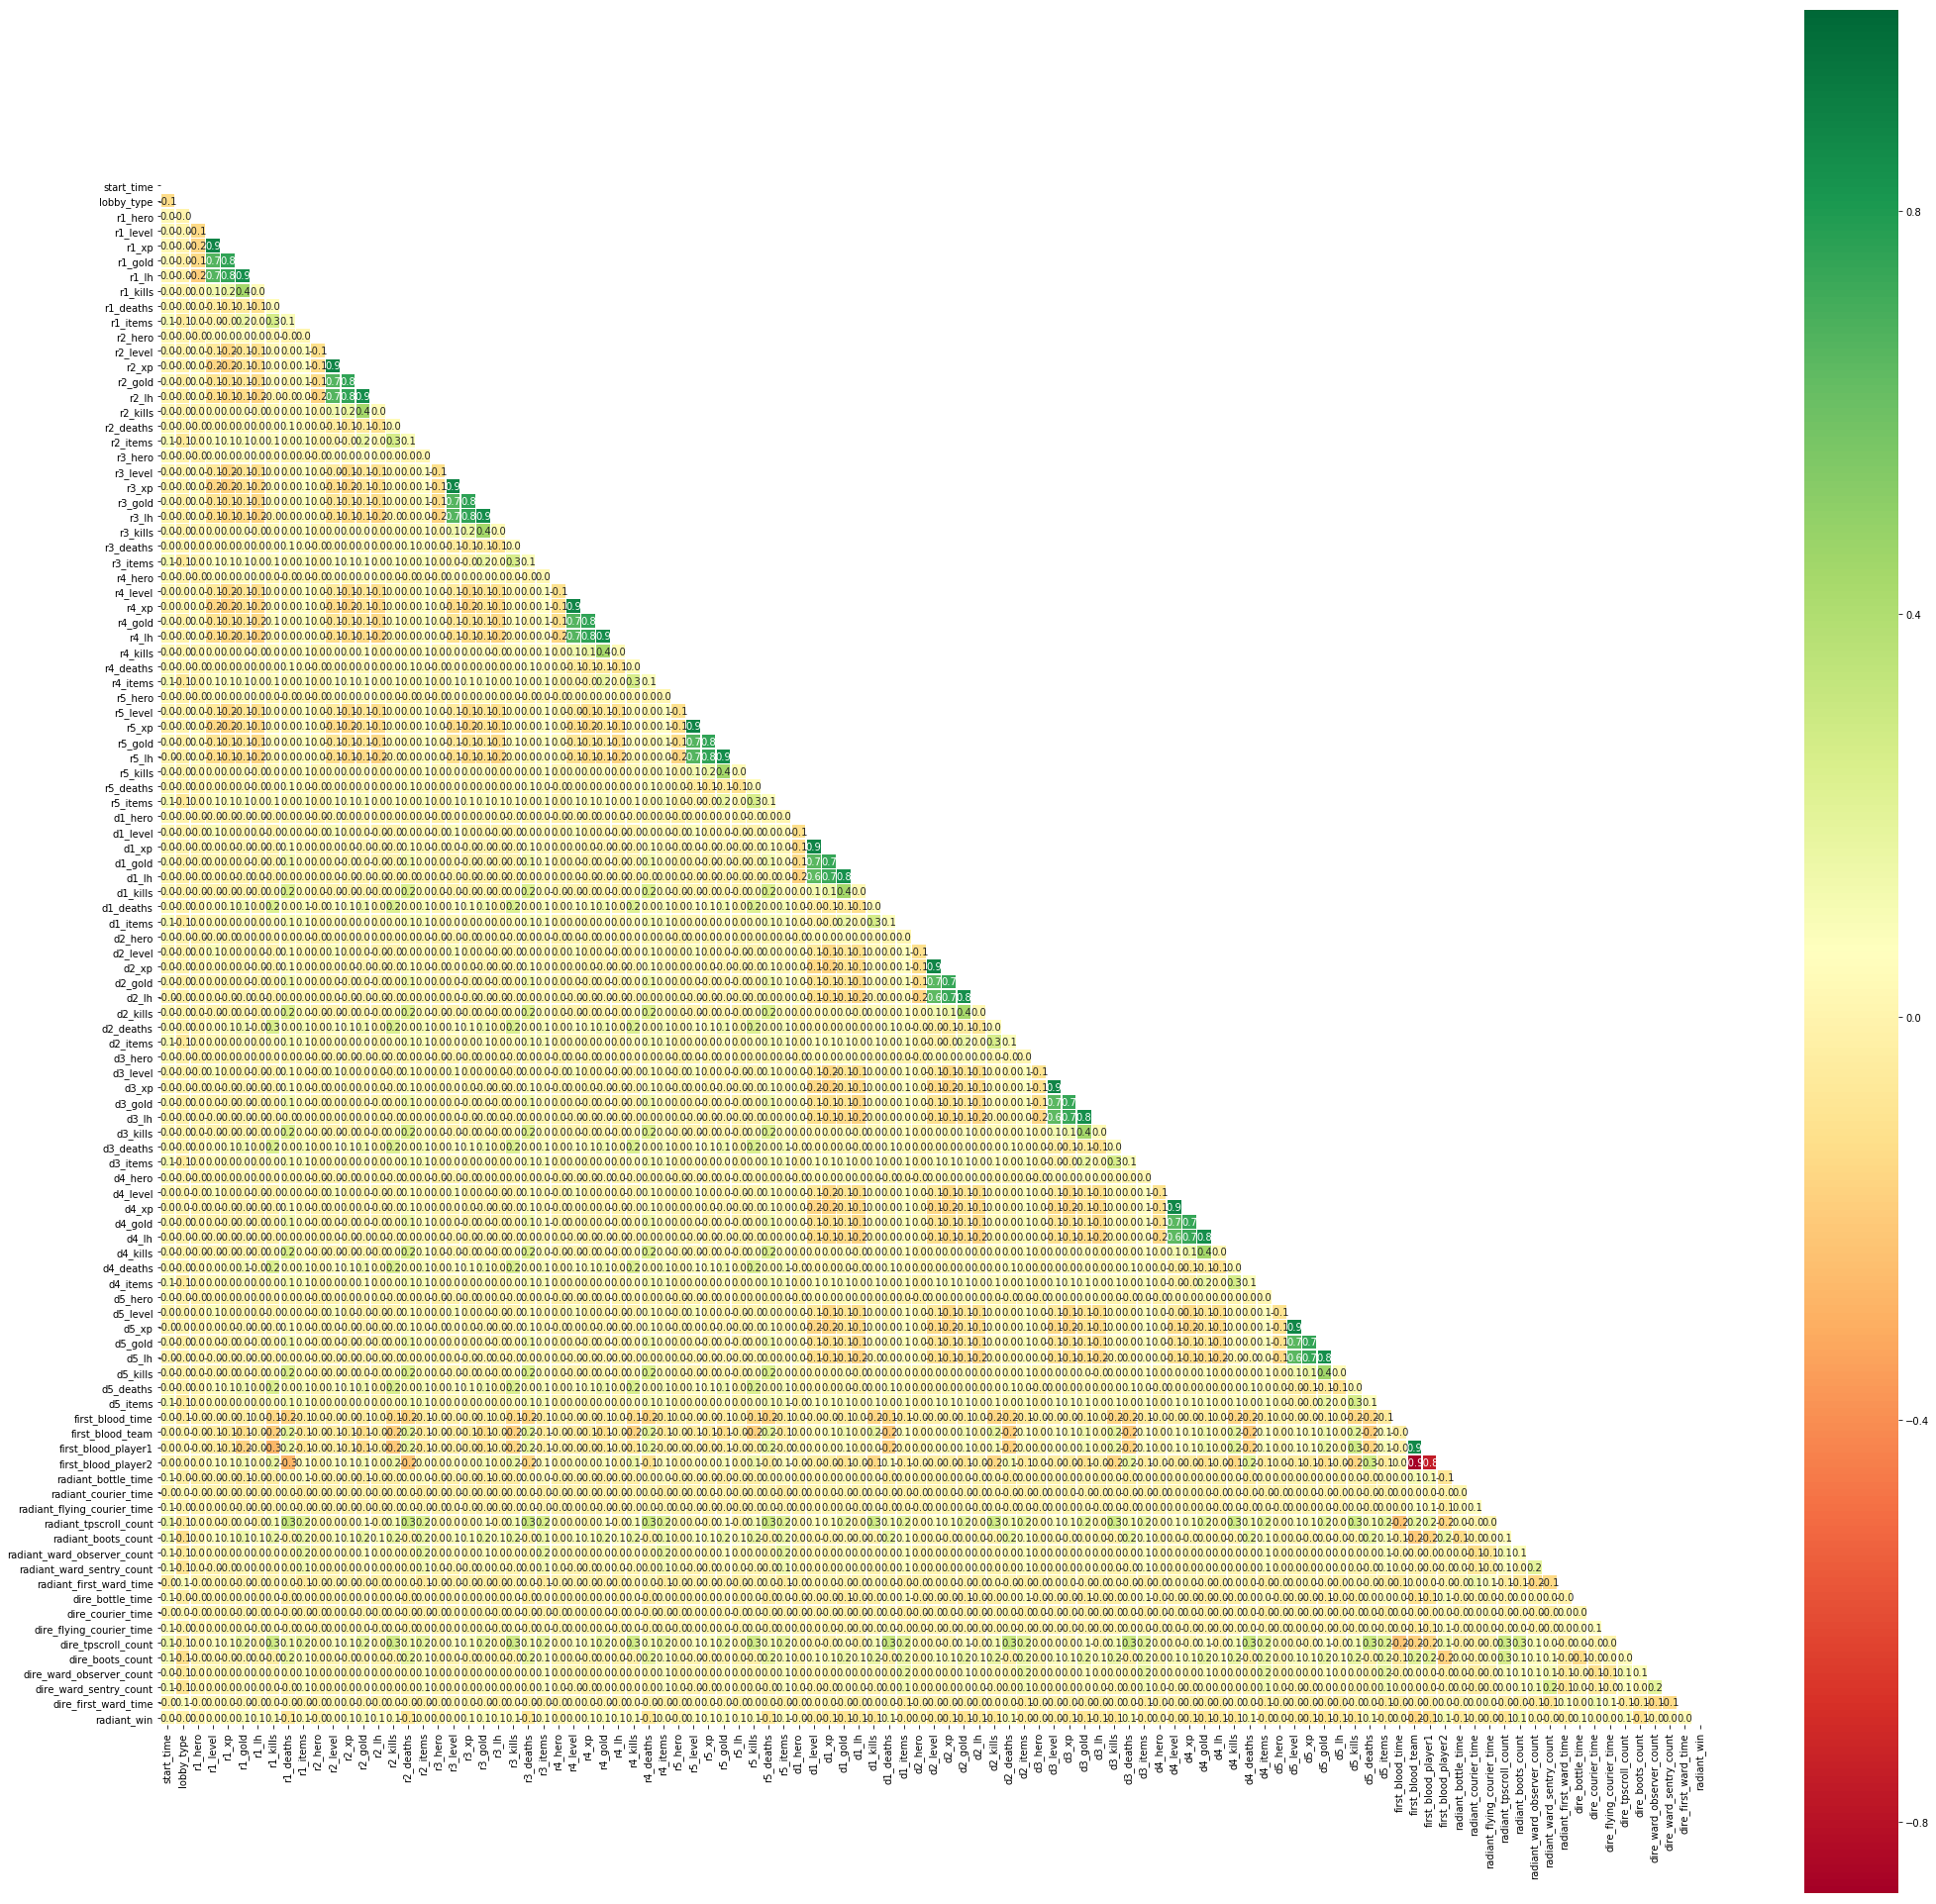

In [4]:
corr = train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(35, 35))
sns.heatmap(corr, cmap="RdYlGn", square=True, linewidths=.5, mask=mask, annot=True, fmt=".1f")

In [28]:
corr1 = corr.loc['radiant_win'].to_frame()

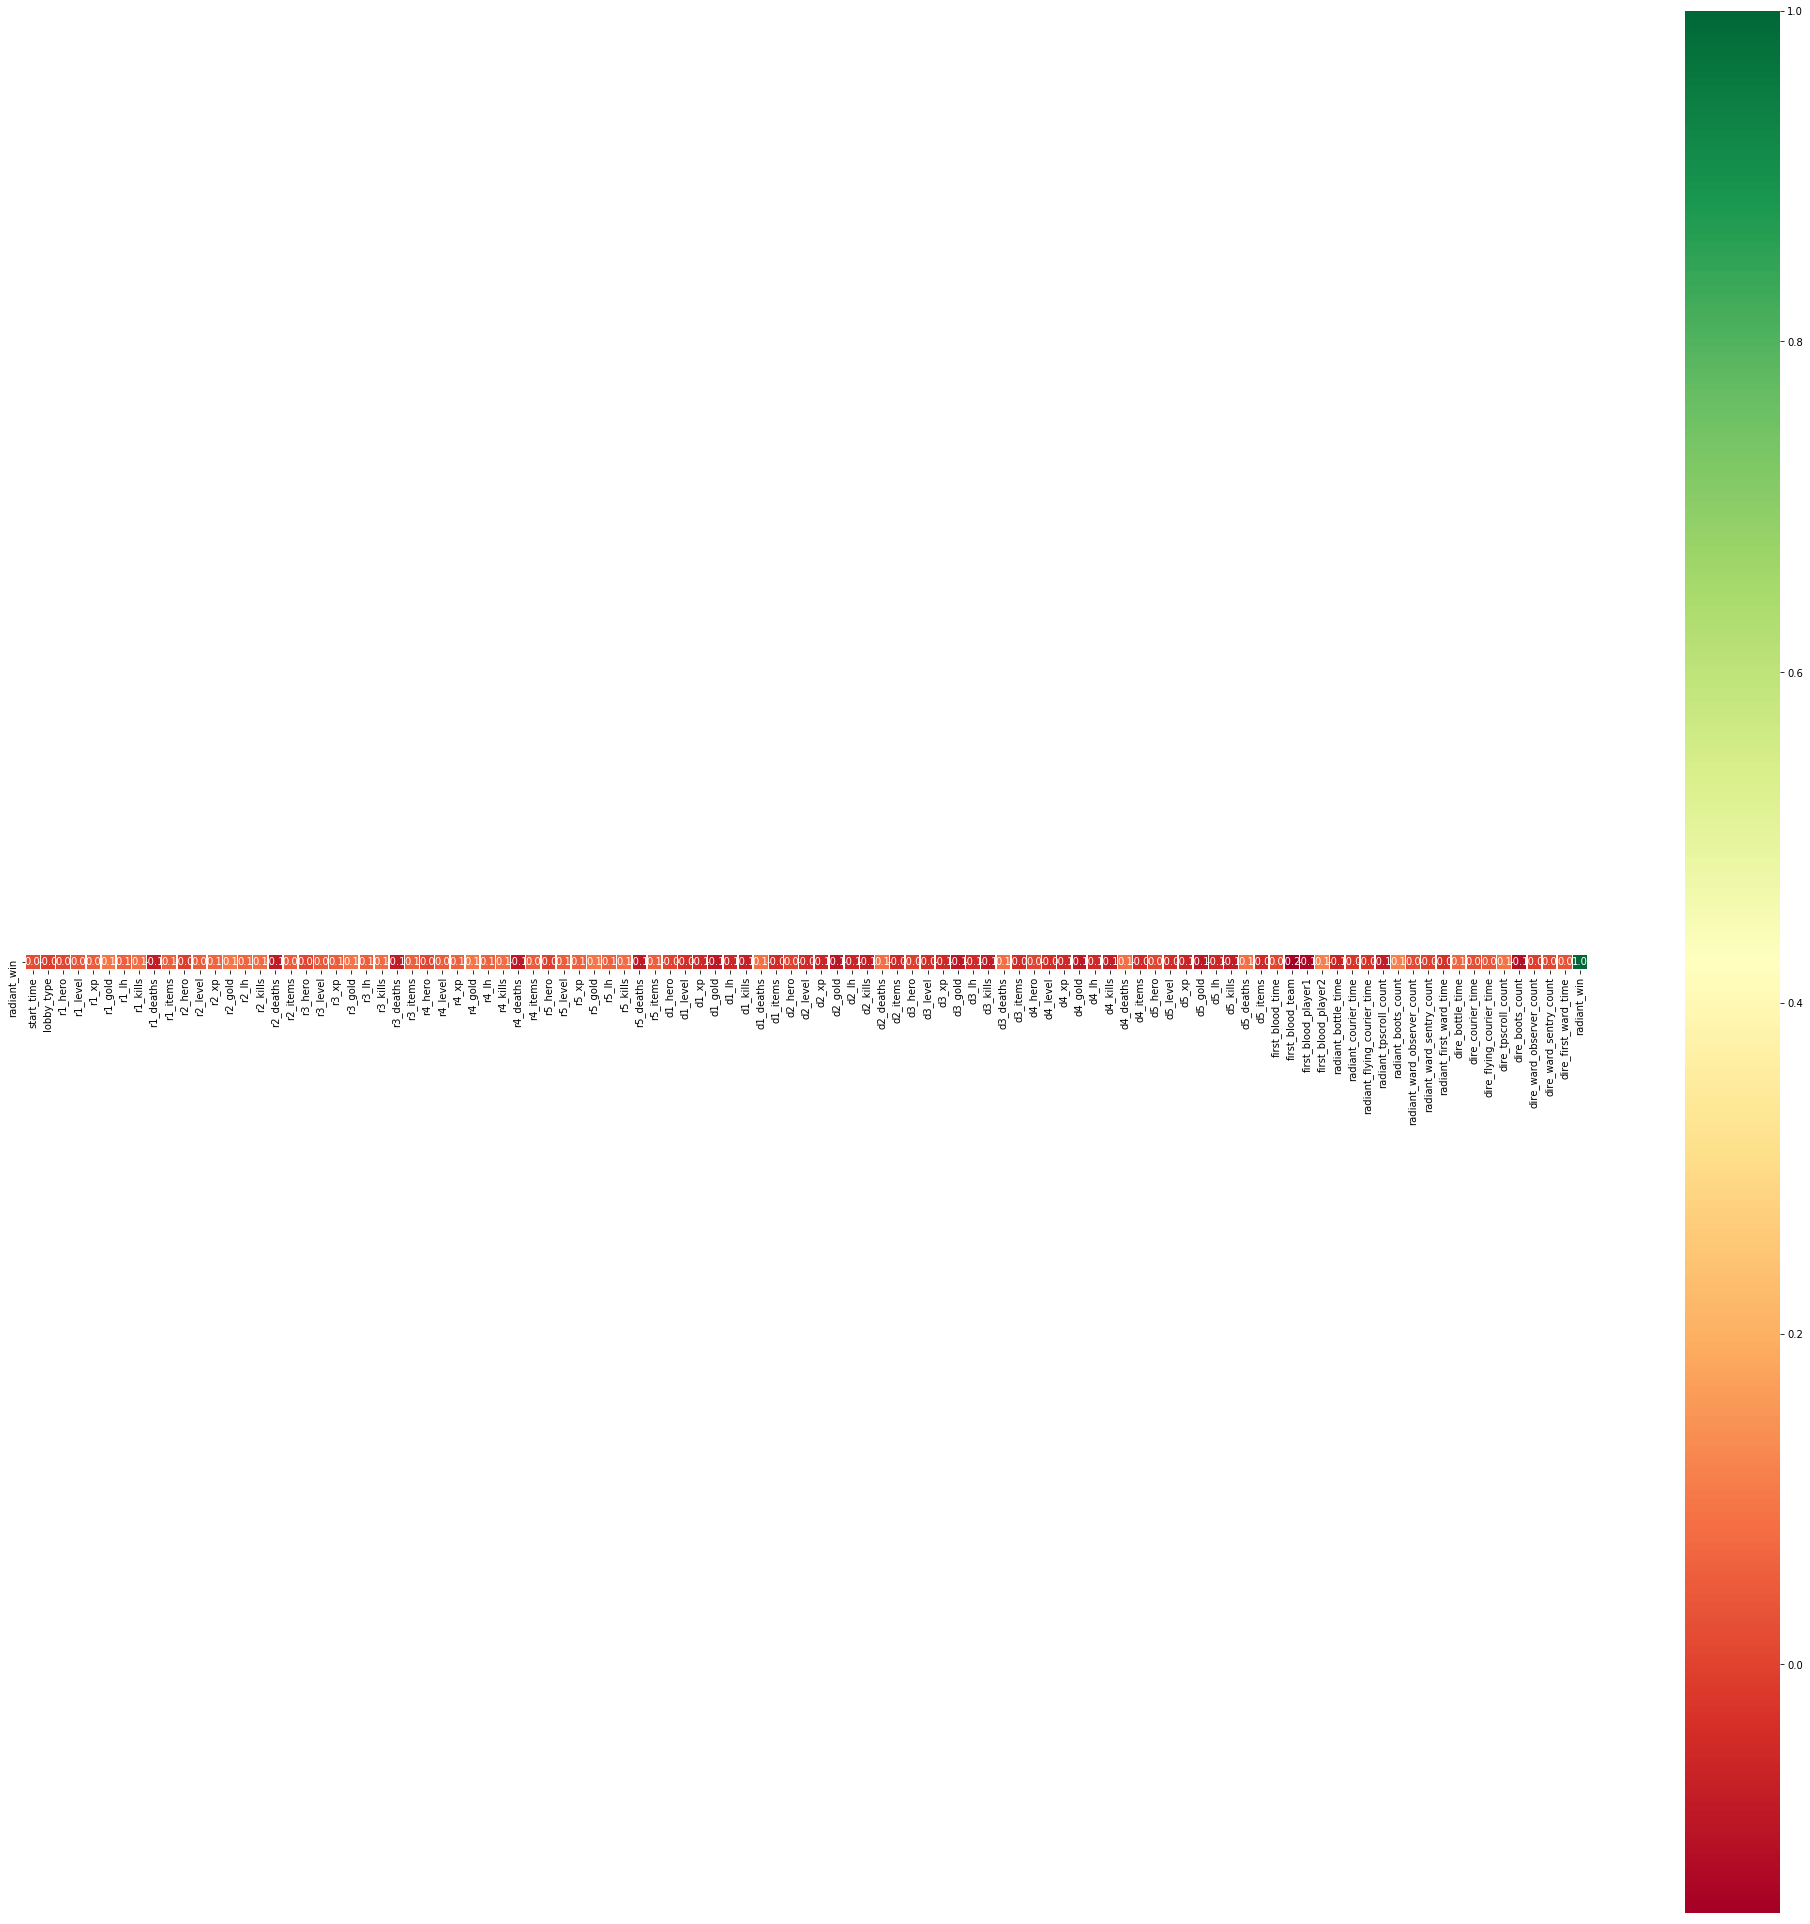

In [13]:
f, ax = plt.subplots(figsize=(35, 35))
sns.heatmap(corr1.T, cmap="RdYlGn", square=True, linewidths=.5, annot=True, fmt=".1f")

In [34]:
corr2 = corr1[corr1 > .01].dropna().T

In [37]:
corr2.drop(['radiant_win'], axis=1, inplace=True)

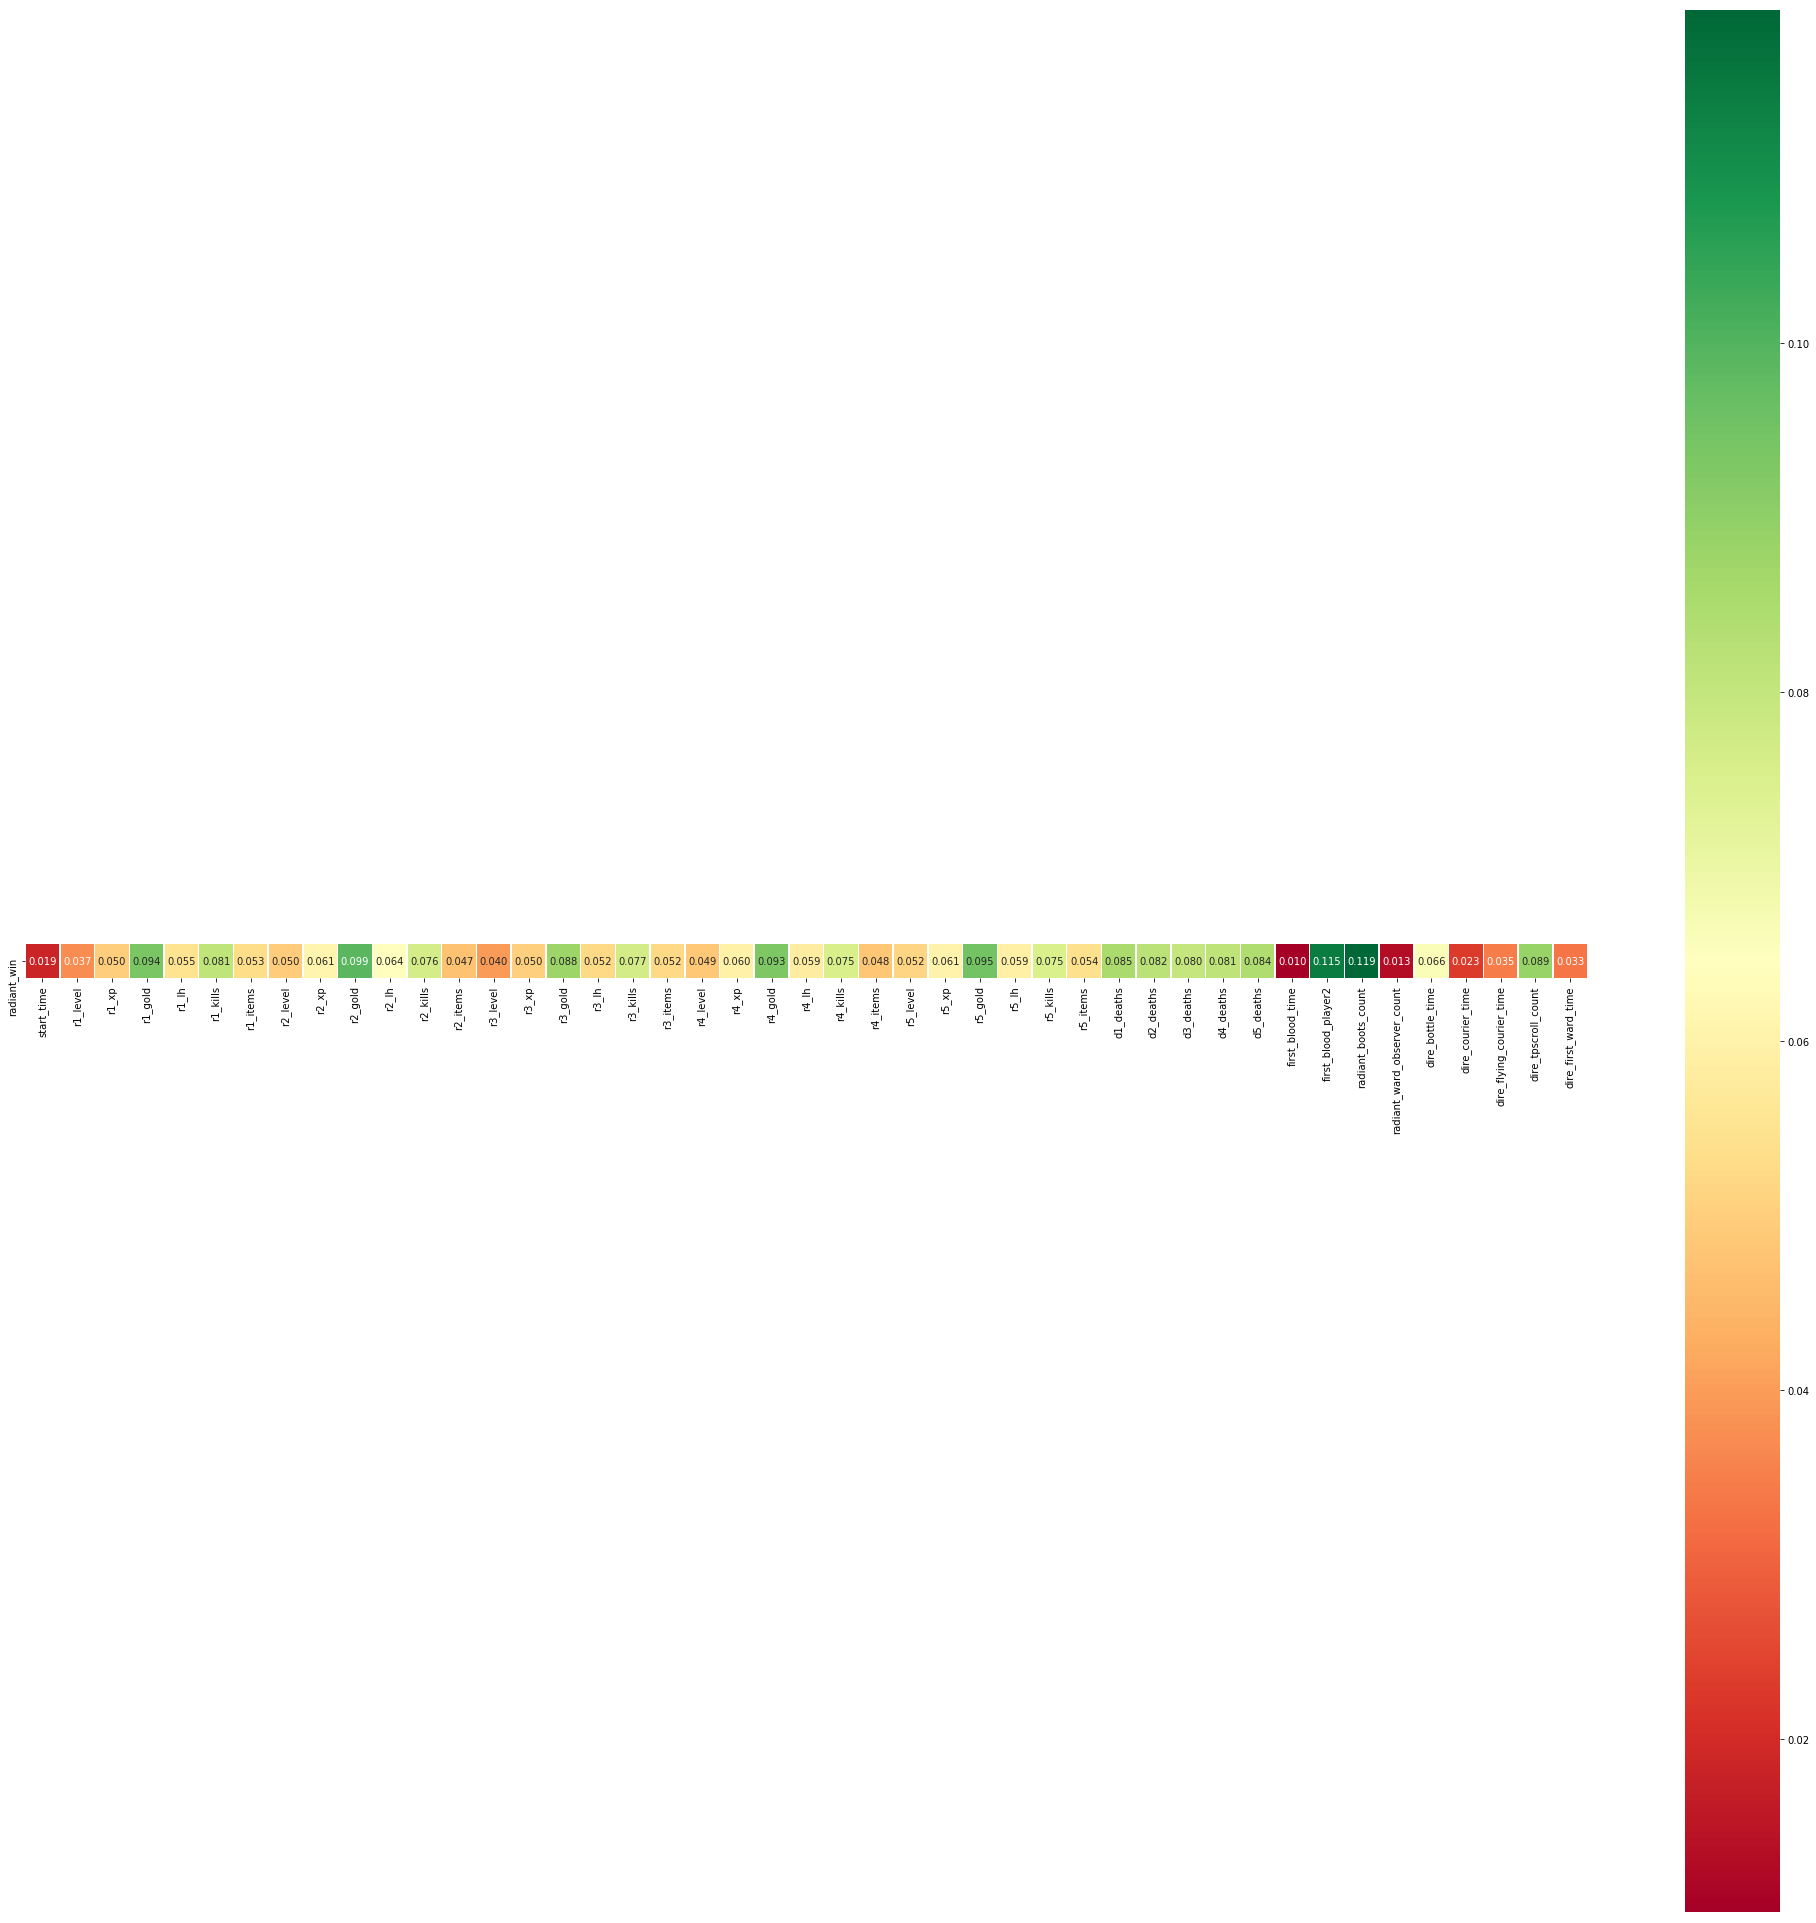

In [39]:
f, ax = plt.subplots(figsize=(35, 35))
sns.heatmap(corr2, cmap="RdYlGn", square=True, linewidths=.5, annot=True, fmt=".3f")

In [64]:
features_corr = corr2.sort_values(by='radiant_win', axis=1, ascending=False)

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
X = train.drop(["radiant_win"], axis=1)
y = train.radiant_win

In [98]:
fill_cont(X)

In [42]:
rf = RandomForestClassifier(n_jobs=7, random_state=42,)

In [47]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=7,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [53]:
features = sorted(list(zip(list(rf.feature_importances_), list(X.columns))), key=lambda item: item[0], reverse=True)

In [54]:
features

[(0.021473090277856231, 'd2_gold'),
 (0.02088374762802073, 'r2_gold'),
 (0.020716560346735819, 'r1_gold'),
 (0.020632994796694552, 'd1_gold'),
 (0.020168141934226967, 'd3_gold'),
 (0.020107768124467539, 'r5_gold'),
 (0.020105695645526743, 'd4_gold'),
 (0.019264549139856368, 'd5_gold'),
 (0.018701614286123762, 'r4_gold'),
 (0.018602509530482363, 'r3_gold'),
 (0.017443972213245201, 'r3_xp'),
 (0.016811796303108743, 'r2_xp'),
 (0.016731600642365042, 'd3_xp'),
 (0.016545301413451192, 'r1_xp'),
 (0.016506404604637002, 'd1_xp'),
 (0.016305795699626795, 'r4_xp'),
 (0.01626159729789264, 'r5_xp'),
 (0.016239753386588958, 'd5_xp'),
 (0.016223399681011112, 'd2_xp'),
 (0.016020421967910078, 'd4_xp'),
 (0.014960044404088709, 'start_time'),
 (0.014831918286366092, 'radiant_first_ward_time'),
 (0.0146828924353089, 'dire_first_ward_time'),
 (0.013176501382273203, 'first_blood_time'),
 (0.01306782907101579, 'radiant_bottle_time'),
 (0.013016899764404117, 'd3_hero'),
 (0.013015907503255647, 'd2_hero'),


In [65]:
features_corr

,radiant_boots_count,first_blood_player2,r2_gold,r5_gold,r1_gold,r4_gold,dire_tpscroll_count,r3_gold,d1_deaths,d5_deaths,...,r4_items,r2_items,r3_level,r1_level,dire_flying_courier_time,dire_first_ward_time,dire_courier_time,start_time,radiant_ward_observer_count,first_blood_time
radiant_win,0.119114,0.114789,0.099026,0.095127,0.093568,0.0935,0.088593,0.08792,0.085073,0.084491,...,0.048231,0.047342,0.03951,0.037051,0.034502,0.033432,0.02324,0.018556,0.013225,0.01007


In [67]:
from sklearn.feature_selection import SelectFromModel

In [68]:
model = SelectFromModel(rf, prefit=True)

In [99]:
X_new = model.transform(X)

In [100]:
X_kaggle = test.copy()
fill_cont(X_kaggle)

In [101]:
X_new_kaggle = model.transform(X_kaggle)

In [102]:
X.shape

(97230, 102)

In [103]:
X_new.shape

(97230, 50)

In [104]:
X_new_kaggle.shape

(17177, 50)

In [105]:
from sklearn.preprocessing import StandardScaler

In [106]:
scaler = StandardScaler()

In [107]:
X_new = scaler.fit_transform(X_new)
X_new_kaggle = scaler.transform(X_new_kaggle)

In [109]:
from tqdm import *

In [114]:
Cs = [j*10.**i for i in range(-5, 6) for j in range(1, 3) ]

scores = []

for C in tqdm_notebook(Cs):
    print("C =", C)
    start_time = datetime.datetime.now()
    clf = LogisticRegression(C=C, random_state=42, n_jobs=7)
    clf_scores = cross_val_score(clf, X_new, y, cv=skf, scoring='roc_auc', n_jobs=7)
    print("Time elapsed:", datetime.datetime.now() - start_time)
    print("clf_scores:", clf_scores, '\n')
    print("Mean score:", np.mean(clf_scores))
    scores.append(np.mean(clf_scores))

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

C = 1e-05


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:02.531497
clf_scores: [ 0.71069014  0.71666113  0.71352837  0.71310257  0.71330965] 

Mean score: 0.713458372046
C = 2e-05


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:02.035427
clf_scores: [ 0.71117904  0.71712658  0.71407813  0.7136437   0.71388075] 

Mean score: 0.713981640618
C = 0.0001


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:02.129016
clf_scores: [ 0.71221241  0.71796582  0.71525738  0.71505358  0.71507352] 

Mean score: 0.715112544087
C = 0.0002


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:02.847212
clf_scores: [ 0.71244311  0.71810683  0.71550905  0.71545415  0.71534938] 

Mean score: 0.715372501694
C = 0.001


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.187362
clf_scores: [ 0.71270405  0.71815741  0.71569465  0.71590072  0.71563376] 

Mean score: 0.715618116687
C = 0.002


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:02.852211
clf_scores: [ 0.7127557   0.71814009  0.71568459  0.71597102  0.7156745 ] 

Mean score: 0.715645177907
C = 0.01


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:02.946420
clf_scores: [ 0.71281862  0.71810073  0.71565249  0.71603151  0.71569033] 

Mean score: 0.715658735175
C = 0.02


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.233648
clf_scores: [ 0.7128252   0.71809556  0.71564129  0.71603545  0.71569035] 

Mean score: 0.715657569869
C = 0.1


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.948885
clf_scores: [ 0.71282887  0.71808515  0.71563249  0.71603974  0.71568926] 

Mean score: 0.715655101735
C = 0.2


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:04.072863
clf_scores: [ 0.71283032  0.71808394  0.71563125  0.71604076  0.71568826] 

Mean score: 0.715654904665
C = 1.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.529959
clf_scores: [ 0.71283172  0.71808276  0.71563027  0.71604119  0.71568827] 

Mean score: 0.715654843199
C = 2.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.401299
clf_scores: [ 0.7128316   0.71808217  0.71563054  0.716041    0.71568822] 

Mean score: 0.7156547055
C = 10.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.567527
clf_scores: [ 0.71283159  0.71808202  0.71563048  0.7160414   0.71568816] 

Mean score: 0.715654728802
C = 20.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:04.860982
clf_scores: [ 0.71283155  0.71808199  0.71563051  0.71604142  0.71568827] 

Mean score: 0.71565474999
C = 100.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.179289
clf_scores: [ 0.71283157  0.71808195  0.71563035  0.71604131  0.71568822] 

Mean score: 0.71565467796
C = 200.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.842586
clf_scores: [ 0.71283152  0.71808193  0.71563031  0.71604135  0.71568822] 

Mean score: 0.71565466525
C = 1000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:04.739811
clf_scores: [ 0.71283154  0.71808195  0.71563031  0.71604132  0.71568822] 

Mean score: 0.715654667368
C = 2000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:04.082138
clf_scores: [ 0.71283154  0.71808196  0.71563031  0.71604131  0.71568822] 

Mean score: 0.715654667368
C = 10000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.099150
clf_scores: [ 0.71283154  0.71808196  0.71563031  0.7160413   0.71568822] 

Mean score: 0.71565466525
C = 20000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.234720
clf_scores: [ 0.71283154  0.71808196  0.71563031  0.7160413   0.71568821] 

Mean score: 0.715654663131
C = 100000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:04.370058
clf_scores: [ 0.71283154  0.71808196  0.71563031  0.7160413   0.71568821] 

Mean score: 0.715654663131
C = 200000.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 's

Time elapsed: 0:00:03.148434
clf_scores: [ 0.71283154  0.71808196  0.71563031  0.7160413   0.71568821] 

Mean score: 0.715654663131



Text(0,0.5,'score')

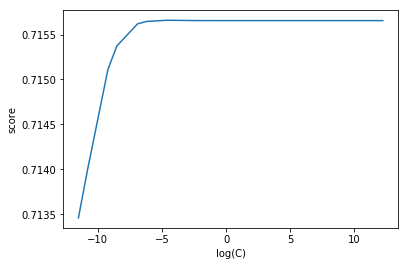

In [115]:
plt.plot(np.log(Cs), scores)
plt.xlabel("log(C)")
plt.ylabel("score")

In [116]:
sorted(list(zip(Cs, scores)), key=lambda item: item[1], reverse=True)

[(0.01, 0.71565873517530476),
 (0.02, 0.71565756986898688),
 (0.1, 0.71565510173488422),
 (0.2, 0.71565490466534465),
 (1.0, 0.71565484319942674),
 (20.0, 0.71565474998974699),
 (10.0, 0.71565472880191605),
 (2.0, 0.71565470549962584),
 (100.0, 0.71565467796001125),
 (1000.0, 0.71565466736804351),
 (2000.0, 0.71565466736804351),
 (200.0, 0.71565466525001176),
 (10000.0, 0.71565466524955945),
 (20000.0, 0.71565466313086512),
 (100000.0, 0.71565466313086512),
 (200000.0, 0.71565466313086512),
 (0.002, 0.71564517790732818),
 (0.001, 0.71561811668688269),
 (0.0002, 0.71537250169390387),
 (0.0001, 0.71511254408693503),
 (2e-05, 0.71398164061788838),
 (1e-05, 0.71345837204622109)]

Получили score = 0.71565873517530476 при C = 0.01, что даже чуть меньше того, что мы получали в первой модели логистической регрессии.

Дальнейшее пока не доработано, потому оцениванию не подлежит.

In [121]:
def hist_by_radiant_win(df, field, bins=50):
    groups = df.groupby('radiant_win')[field]
    fig, ax = plt.subplots()
    for k, v in reversed(list(groups)):
        v.hist(label=str(k), alpha=.75, ax=ax, bins=bins)
    ax.legend(title='radiant_win')

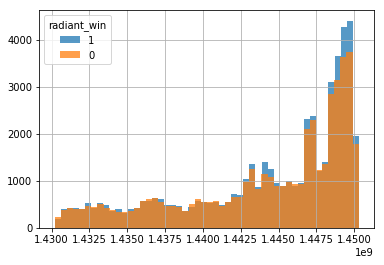

In [122]:
hist_by_radiant_win(train, 'start_time')

In [125]:
lobbies_types = train.lobby_type.unique()

In [126]:
lobbies = pd.read_csv('./../data/dictionaries/lobbies.csv')

In [137]:
lobbies

,id,name
0,-1,Invalid
1,0,Public matchmaking
2,1,Practice
3,2,Tournament
4,3,Tutorial
5,4,Co-op with bots
6,5,Team match
7,6,Solo Queue
8,7,Ranked
9,8,Solo Mid 1vs1


In [130]:
lobbies_types

array([7, 0, 1])

In [148]:
lt = lobbies.name[list(lobbies_types)]

In [149]:
lt

7            Solo Queue
0               Invalid
1    Public matchmaking
Name: name, dtype: object

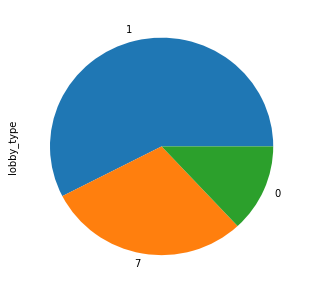

In [154]:
train.lobby_type.value_counts().plot.pie(figsize=(5, 5))

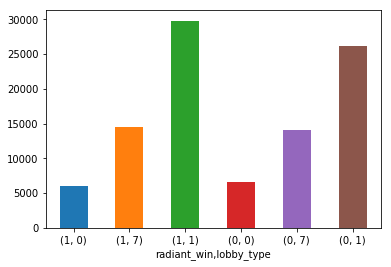

In [161]:
train.groupby('radiant_win')['lobby_type'].value_counts().iloc[::-1].T.plot.bar(rot=0)